# Info
Name:  

    KORUS_AOD_fine_coarse_autocorr
    
Purpose:  

    Analyse some of the AOD values from KORUS AQ
    Split up between fine mode and coarse mode AOD
    Subset for level legs only
        - interpolate within the level legs
    Run autocorrelation values for the distance/time travelled 
  
Input:

    None at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - hdf5 python loader
    - 
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - '/aod_ict/all_aod_KORUS_R2_ict.mat'
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-05-18
    Modified: 

# Prepare python environment

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import Sp_parameters as Sp
from load_utils import mat2py_time, toutc, load_ict
import load_utils as lu
import plotting_utils as pu
from path_utils import getpath
import hdf5storage as hs
from datetime import datetime
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import scipy.stats as st

In [287]:
import map_utils as mu
from scipy import interpolate
import math

In [3]:
from linfit import linfit
import Sun_utils as su

In [4]:
%matplotlib notebook

In [5]:
fp =getpath('KORUS')

Return path named:  KORUS /data/sam/KORUS-AQ/


# Load files

Load the KORUS 4STAR AOD ict files for better handling

In [6]:
ar = hs.loadmat(fp+'/aod_ict/all_aod_KORUS_R2_ict.mat')

In [7]:
ka = ar.keys()

In [8]:
ka.sort()

In [9]:
ka

[u'AOD0380',
 u'AOD0452',
 u'AOD0501',
 u'AOD0520',
 u'AOD0532',
 u'AOD0550',
 u'AOD0606',
 u'AOD0620',
 u'AOD0675',
 u'AOD0781',
 u'AOD0865',
 u'AOD1020',
 u'AOD1040',
 u'AOD1064',
 u'AOD1236',
 u'AOD1559',
 u'AOD1627',
 u'GPS_Alt',
 u'Latitude',
 u'Longitude',
 u'Start_UTC',
 u'UNCAOD0380',
 u'UNCAOD0452',
 u'UNCAOD0501',
 u'UNCAOD0520',
 u'UNCAOD0532',
 u'UNCAOD0550',
 u'UNCAOD0606',
 u'UNCAOD0620',
 u'UNCAOD0675',
 u'UNCAOD0781',
 u'UNCAOD0865',
 u'UNCAOD1020',
 u'UNCAOD1040',
 u'UNCAOD1064',
 u'UNCAOD1236',
 u'UNCAOD1559',
 u'UNCAOD1627',
 u'amass_aer',
 u'days',
 u'fl',
 u'fl1',
 u'fl2',
 u'fl_QA',
 u'fl_alt',
 u'fl_alt1',
 u'qual_flag']

In [10]:
nwl = ka[0:17]

In [11]:
nwl

[u'AOD0380',
 u'AOD0452',
 u'AOD0501',
 u'AOD0520',
 u'AOD0532',
 u'AOD0550',
 u'AOD0606',
 u'AOD0620',
 u'AOD0675',
 u'AOD0781',
 u'AOD0865',
 u'AOD1020',
 u'AOD1040',
 u'AOD1064',
 u'AOD1236',
 u'AOD1559',
 u'AOD1627']

In [12]:
nm = [380.0,452.0,501.0,520.0,532.0,550.0,606.0,620.0,675.0,781.0,865.0,1020.0,1040.0,1064.0,1236.0,1559.0,1627.0]

# Run analysis and prepare variables
Do some of the calculations to the data here

In [126]:
fl1 = ar['days']==ar['days'][0]

In [127]:
fl1.shape

(583183,)

In [128]:
fl = (ar['fl_QA']==0) & (np.isfinite(ar['AOD0501'])) 

In [129]:
fl1.shape

(583183,)

## Calculate the Angstrom Exponent

In [88]:
nwl,nm

([u'AOD0380',
  u'AOD0452',
  u'AOD0501',
  u'AOD0520',
  u'AOD0532',
  u'AOD0550',
  u'AOD0606',
  u'AOD0620',
  u'AOD0675',
  u'AOD0781',
  u'AOD0865',
  u'AOD1020',
  u'AOD1040',
  u'AOD1064',
  u'AOD1236',
  u'AOD1559',
  u'AOD1627'],
 [380.0,
  452.0,
  501.0,
  520.0,
  532.0,
  550.0,
  606.0,
  620.0,
  675.0,
  781.0,
  865.0,
  1020.0,
  1040.0,
  1064.0,
  1236.0,
  1559.0,
  1627.0])

In [89]:
aodrr = np.array([ar[n] for n in nwl])

In [90]:
aodrr.shape

(17, 583183)

In [91]:
angs = su.calc_angs(ar['Start_UTC'],np.array(nm[1:11]),aodrr[1:11,:])

A Jupyter Widget

Sun_utils.py:607: RuntimeWarning: divide by zero encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))
linfit.py:224: RuntimeWarning: invalid value encountered in double_scalars
  yint = (sy - sx * slope)/s
Sun_utils.py:607: RuntimeWarning: invalid value encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))


## Subset the level legs

In [140]:
def running_std(x,n):
    'Function to do a running standard deviation on array (x) with window size (n)'
    q = x**2
    q = np.convolve(q, np.ones((n, )), mode="same")
    s = np.convolve(x, np.ones((n, )), mode="same")
    o = (q-s**2/n)/float(n-1)
    return o 

In [141]:
nbox = 20

In [142]:
std_alt = running_std(ar['GPS_Alt'][fl],nbox)

In [143]:
std_alt.shape

(148896,)

In [144]:
ar['GPS_Alt'][fl].shape

(148896,)

In [145]:
f_level = np.where(std_alt<5.0)[0]

In [146]:
std_alt1 = running_std(ar['GPS_Alt'][fl1],nbox)

In [147]:
f_level1 = np.where(std_alt1<5.0)[0]

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [149]:
ar['Start_UTC'][fl1][f_level1]

array([22.50277778, 22.50305556, 22.50333333, ..., 30.67222222,
       30.6725    , 30.67277778])

<IPython.core.display.Javascript object>


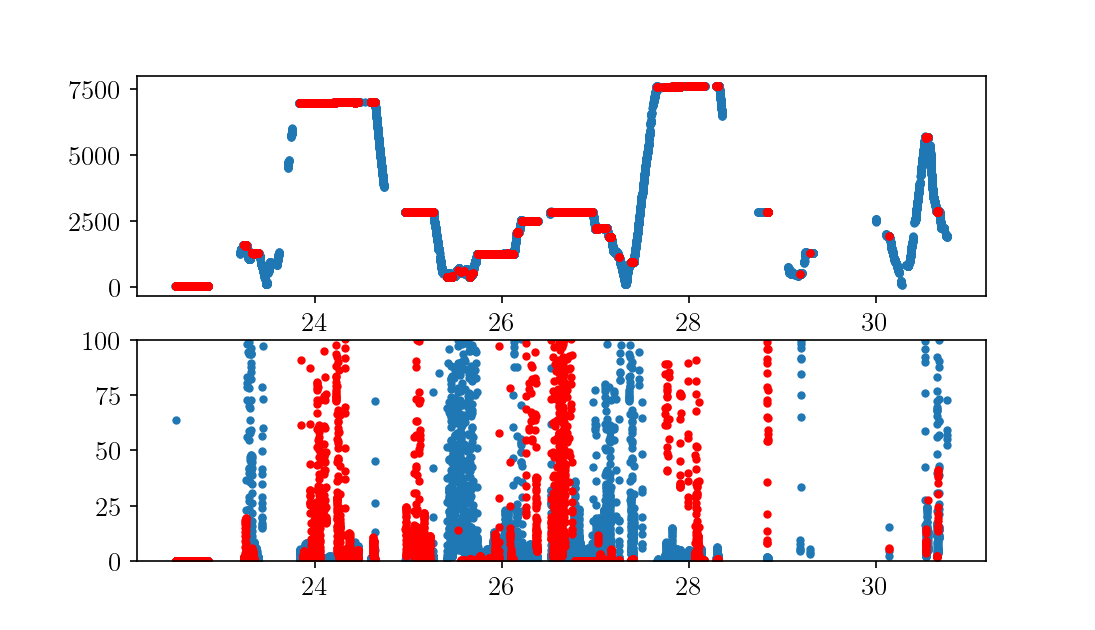

(0, 100)

In [151]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(ar['Start_UTC'][fl1],ar['GPS_Alt'][fl1],'.')
plt.plot(ar['Start_UTC'][fl1][f_level1],ar['GPS_Alt'][fl1][f_level1],'r.')


ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(ar['Start_UTC'][fl1],std_alt1,'.')
plt.plot(ar['Start_UTC'][fl1][f_level1],std_alt[f_level1],'r.')
plt.ylim(0,100)


<IPython.core.display.Javascript object>


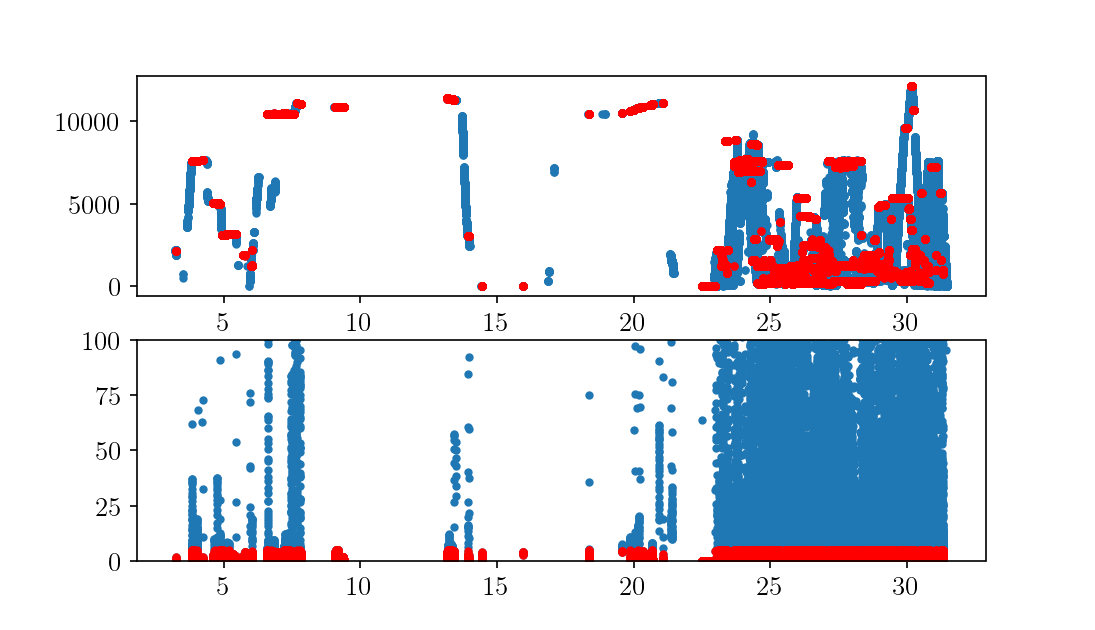

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


(0, 100)

In [152]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(ar['Start_UTC'][fl],ar['GPS_Alt'][fl],'.')
plt.plot(ar['Start_UTC'][fl][f_level],ar['GPS_Alt'][fl][f_level],'r.')


ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(ar['Start_UTC'][fl],std_alt,'.')
plt.plot(ar['Start_UTC'][fl][f_level],std_alt[[f_level]],'r.')
plt.ylim(0,100)

## Seperate each of the level legs into distinct segments

In [183]:
def get_segments(index,vals_dict,nsep=150,set_nan=True):
    'Function to seperate continuous segments (within a distance of nsep) based on a prior index'
    disc_flacaod_long = np.where(np.diff(index,1)>nsep)[0]
    
    discontinuity_istart_long =  index[np.append(0,disc_flacaod_long[:-1]+1)]
    discontinuity_iend_long =  index[disc_flacaod_long]
    
    kv = vals_dict.keys()
    d = {k:[] for k in kv}
    for i,start in enumerate(discontinuity_istart_long): # loop through discontinuities 
        if discontinuity_iend_long[i]-start < 2: continue
        for k in kv: # loop through keys
            try:
                d[k].append(vals_dict[k][start:discontinuity_iend_long[i]])
            except:
                print start, discontinuity_iend_long[i]
                continue
                #d[k].append([np.nan])
    
    for k in kv:
        d[k] = np.array(d[k])
        
    return d

In [184]:
vals = {'utc':ar['Start_UTC'][fl],'alt':ar['GPS_Alt'][fl],'lat':ar['Latitude'][fl],'lon':ar['Longitude'][fl],
        'aod0500':ar['AOD0501'][fl],'aod1040':ar['AOD1040'][fl],'AE':angs[fl]}

In [185]:
dvals = get_segments(f_level,vals,nsep=100)

In [186]:
dvals.keys()

['aod1040', 'utc', 'AE', 'aod0500', 'lon', 'lat', 'alt']

In [157]:
for n in dvals['utc']:
    try:
        print (n[-1]-n[0])*60.0
    except:
        print np.nan

45.416666666666785
3.9500000000000313
47.59999999999998
16.24999999999993
1.0999999999998522
65.78333333333333
1.0666666666668334
0.03333333333323196
1.6833333333332234
70.51666666666655
0.0
50.76666666666661
1.3000000000000966
0.8166666666666345
6.216666666666626
8.499999999999943
0.16666666666658614
34.33333333333337
3.583333333333414
0.6833333333334934
0.5833333333333712
4.1500000000000625
0.14999999999986358
78.46666666666678
1.8666666666667453
4.300000000000139
32.80000000000001
3.2166666666665833
1.9499999999999318
0.03333333333323196
0.03333333333323196
0.33333333333338544
0.7666666666666799
4.949999999999974
13.049999999999855
14.666666666666828
6.933333333333351
28.316666666666777
21.94999999999986
7.983333333333462
5.133333333333496
0.4166666666667851
37.88333333333334
0.8166666666666345
1.8833333333332547
1.1666666666667425
2.533333333333303
1.1166666666665748
16.116666666666575
227.64999999999992
5.3999999999999915
0.9833333333332206
0.40000000000006253
30.266666666666495
7

In [188]:
def discrete_matshow(data,cmapname='RdBu'):
    ' plotting function for a discrete colormap'
    cmap = plt.get_cmap(cmapname, np.nanmax(data)-np.nanmin(data)+1)
    # set limits .5 outside true range
    scalarmap = plt.cm.ScalarMappable(cmap=cmapname)
    scalarmap.set_array(data)
    #mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(scalarmap, ticks=np.arange(np.min(data),np.max(data)+1))
    return cax

In [ ]:
for q in np.unique(ar['days']):
    flq = ar['days'][fl]==q
    flql = ar['days'][fl][f_level]==q
    plt.figure()
    plt.plot(ar['Start_UTC'][fl][flq],ar['GPS_Alt'][fl][flq],'.')
    plt.plot(ar['Start_UTC'][fl][f_level][flql],ar['GPS_Alt'][fl][f_level][flql],'r.')
    ax = plt.gca()

    ax.set_color_cycle([plt.cm.gist_ncar(k) for k in np.linspace(0, 1, len(dvals['utc'])+1)])

    for i,n in enumerate(dvals['utc']):
        plt.plot(n,dvals['alt'][i],'s-',markeredgecolor='None')

    plt.xlabel('UTC [h from midnight]')
    plt.ylabel('Altitude [m]')
    plt.title('Days: {}'.format(q))

    #scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('gist_ncar'))
    #scalarmap.set_array(range(len(dvals['utc'])+1))
    #cb = plt.colorbar(scalarmap)
    cb = discrete_matshow(range(len(dvals['utc'])+1),cmapname='gist_ncar')
    cb.set_label('Level leg number')
#plt.plot(ar['Start_UTC'][fl1][f_level],ar['GPS_Alt'][fl1][f_level],'r.')

## Now calculate the distances travelled within each segments

In [189]:
def get_distances(seg_dict):
    'Function that calculates the cumulative distance and instantaneous change between each point for a set of segments'
    seg_dict['dist'],seg_dict['cumdist'] = [],[]
    for i,l in enumerate(seg_dict['lat']):
        try:
            ckm,km = [],[]
            pos1 = [seg_dict['lat'][i][0],seg_dict['lon'][i][0]] 
            for j,a in enumerate(seg_dict['lat'][i]):
                d = mu.spherical_dist(pos1,[seg_dict['lat'][i][j],seg_dict['lon'][i][j]])
                ckm.append(d)
                km.append(d)
        except:
            cckm,dkm = [np.nan],[np.nan]

        iu = np.where(np.isfinite(ckm))[0]
        try:
            fckm = interpolate.interp1d(seg_dict['utc'][i][iu],np.array(ckm)[iu])
            fkm = interpolate.interp1d(seg_dict['utc'][i][iu],np.array(km)[iu])
            cckm = fckm(seg_dict['utc'][i])
            dkm = fkm(seg_dict['utc'][i])
            seg_dict['cumdist'].append(np.array(cckm))
            seg_dict['dist'].append(np.array(np.diff(dkm)))
        except:
            seg_dict['cumdist'].append(np.array(np.nan))
            seg_dict['dist'].append(np.array(np.nan))

    return seg_dict

In [190]:
ddv = get_distances(dvals)

In [191]:
dvals['cumdist']

[array([ 0.        ,  0.        ,  0.        , ..., 38.5748855 ,
        38.75314675, 38.90739789]),
 array([ 0.        ,  0.1064812 ,  0.21373213,  0.31441346,  0.42175507,
         1.29092221,  1.39738101,  1.50503797,  1.61236964,  1.7200196 ,
         1.82769429,  1.93934155,  2.1202961 ,  3.1529191 ,  3.29672172,
         3.45493055,  3.55008179,  3.563959  ,  3.78428911,  3.90356981,
         4.01799051,  4.13122304,  4.31221924,  4.47040009,  4.58397088,
         4.69838303,  4.81095067,  4.92060508,  5.04130839,  5.15416776,
         5.26850769,  5.382923  ,  5.49615015,  5.68162771,  5.84658886,
         5.96382811,  6.07823368,  6.19222737,  6.30533096,  6.42006961,
         6.53966053,  6.65429927,  6.768707  ,  6.88601739,  7.07596578,
         7.24190595,  7.35777671,  7.47083232,  7.5831651 ,  7.69371275,
         7.80552155,  7.9159888 ,  8.02797079,  8.13915292,  8.2491714 ,
         8.42506922,  8.57626882,  8.68379969,  8.7923609 ,  8.89742582,
         9.00285817,  9

In [192]:
dvals.keys()

['aod1040', 'utc', 'AE', 'aod0500', 'lon', 'cumdist', 'lat', 'dist', 'alt']

## Calculate the autocorrelation of AOD with respect to distance

**From Shinozuka and Redemann, 2011, Horizontal variability of aerosol optical depth observed during the ARCTAS airborne experiment, ACP**

Autocorrelation is the correlation coefficient among all
data pairs xj and xj+k that exist at a separation, or lag, of k. That is,

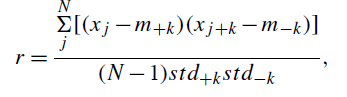

where k indicates the spatial lag (or distance), m+k and std+k denote the mean and standard deviation, respectively, of all data points that are located a distance of +k away from an- other data point, and m−k and std−k are the corresponding quantities for data points located a distance of −k away from another data point (Redemann et al., 2006; Anderson et al., 2003).
Figure 1c shows pairs of 499nm AOD measured 20km (±0.2 km) away from each other in the Canada phase. The correlation coefficient, r, is 0.37. This is the autocorrelation for 20km.

### Test out Shinozuka & Redemann autocorrelation 

In [263]:
dvals['cumdist'][2]

array([0.00000000e+00, 1.52460168e-01, 3.09808070e-01, 5.86067543e-01,
       8.01333704e-01, 9.58783600e-01, 1.11269273e+00, 1.26962440e+00,
       1.42901633e+00, 1.59074522e+00, 1.74891958e+00, 1.90509668e+00,
       2.05719335e+00, 2.21461958e+00, 2.49567172e+00, 2.70895078e+00,
       2.86607779e+00, 3.02323546e+00, 3.17925213e+00, 3.33229874e+00,
       3.48882108e+00, 3.64740691e+00, 3.80978181e+00, 3.96830128e+00,
       4.12664572e+00, 4.39813014e+00, 4.60713051e+00, 4.76547290e+00,
       4.92281956e+00, 5.07747719e+00, 5.23053325e+00, 5.38707156e+00,
       9.84031460e+00, 9.99229133e+00, 1.01544060e+01, 1.03078527e+01,
       1.05779269e+01, 1.07869382e+01, 1.09452684e+01, 1.10996880e+01,
       1.12518143e+01, 1.14084631e+01, 1.15659591e+01, 1.17182202e+01,
       1.18744478e+01, 1.20326668e+01, 1.21855679e+01, 1.24556709e+01,
       1.26647360e+01, 1.28218881e+01, 1.29761861e+01, 1.31304926e+01,
       1.32866292e+01, 1.34379129e+01, 1.35958848e+01, 1.37479094e+01,
      

In [230]:
dvals.keys()

['aod1040',
 'utc',
 'AE',
 'aod1040_r',
 'aod0500',
 'lon',
 'cumdist',
 'cdist_n',
 'AE_r',
 'aod_n',
 'lat',
 'dist',
 'alt',
 'autocor']

In [288]:
math.gamma(10)

362880.0

In [320]:
cr = []
for i,cd in enumerate(dvals['cumdist']):
    #cd = dvals['cumdist'][i]
    corr = {'aod1040':[],'aod0500':[],'AE':[]}
    corr_ks =[0.1,0.25,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.5,10.0,12.5,15.0,20.0,
              25.0,30.0,35.0,40.0,50.0,60.0,75.0,100.0,150.0,200.0] 
    for ik, k in enumerate(corr_ks):

    #k = 5.0 # for 5km distance
        if k>np.nanmax(cd):
            [corr[val].append(np.nan) for val in corr.keys()]
            continue
        ipk = np.argmin(abs(cd-k)) #ipk:
        imk = np.argmin(abs(cd-(cd[-1]-k))) #0:imk
        N = len(cd)
        #c = np.sqrt(2.0/(N-1))*math.gamma(N/2.0)/math.gamma((N-1.0)/2.0)

        for val in dvals.keys():
            if val in ['lon','utc','lat','cumdist','cdist_n','dist','alt','autocor','aod1040_r','AE_r','aod_n']: continue
            #print val, len(dvals[val][i])
            mpk = np.nanmean(dvals[val][i][ipk:]) #mean +k
            mmk = np.nanmean(dvals[val][i][0:imk]) #mean -k
            spk = np.nanstd(dvals[val][i][ipk:]) #std +k
            smk = np.nanstd(dvals[val][i][0:imk]) #std -k
            top = [(dvals[val][i][j]-mpk)*(dvals[val][i][j+ipk]-mmk) for j in xrange(N-ipk-1)]
            #dvals[val+'_r'] = []
            corr[val].append(np.sum(top)/((N-1)*spk*smk))
            if (corr[val][-1]>1.0) | (corr[val][-1]<0.0):
                print '{} has bad corr: {:2.2f} val for key {}: std+k:{:2.2f}, std-k:{:2.2f}, m+k:{:2.2f}, m-k:{:2.2f} '.format(i,
                    corr[val][-1],val,spk,smk,mpk,mmk)

    for val in corr.keys():
        corr[val] = np.array(corr[val])
    cr.append(corr)

0 has bad corr: 1.00 val for key aod1040: std+k:0.41, std-k:0.41, m+k:0.55, m-k:0.55 
0 has bad corr: 1.00 val for key aod0500: std+k:0.37, std-k:0.37, m+k:0.81, m-k:0.81 
0 has bad corr: 1.00 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.78 
0 has bad corr: 1.00 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.78 
0 has bad corr: 1.00 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.78 
0 has bad corr: 1.00 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.78 
0 has bad corr: 1.01 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.78 
0 has bad corr: 1.01 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.79 
0 has bad corr: 1.01 val for key AE: std+k:0.39, std-k:0.39, m+k:0.78, m-k:0.79 
0 has bad corr: 1.02 val for key AE: std+k:0.39, std-k:0.38, m+k:0.78, m-k:0.80 
0 has bad corr: -0.19 val for key aod1040: std+k:0.30, std-k:0.41, m+k:0.86, m-k:0.54 
0 has bad corr: -3.71 val for key AE: std+k:0.06, std-k:0.38, m+k:0.12, m-k:0.81 
0 has bad c

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


2 has bad corr: -0.10 val for key aod1040: std+k:0.33, std-k:0.35, m+k:0.27, m-k:0.33 
2 has bad corr: -0.08 val for key AE: std+k:0.39, std-k:0.39, m+k:0.54, m-k:0.46 
2 has bad corr: -0.10 val for key aod0500: std+k:0.35, std-k:0.33, m+k:0.32, m-k:0.37 
2 has bad corr: -0.10 val for key aod1040: std+k:0.33, std-k:0.36, m+k:0.27, m-k:0.35 
2 has bad corr: -0.09 val for key AE: std+k:0.39, std-k:0.39, m+k:0.54, m-k:0.43 
2 has bad corr: -0.10 val for key aod0500: std+k:0.35, std-k:0.33, m+k:0.32, m-k:0.38 
2 has bad corr: -0.10 val for key aod1040: std+k:0.34, std-k:0.37, m+k:0.28, m-k:0.37 
2 has bad corr: -0.12 val for key AE: std+k:0.39, std-k:0.37, m+k:0.55, m-k:0.39 
2 has bad corr: -0.08 val for key aod0500: std+k:0.36, std-k:0.35, m+k:0.34, m-k:0.40 
2 has bad corr: -0.02 val for key aod1040: std+k:0.38, std-k:0.37, m+k:0.31, m-k:0.37 
2 has bad corr: -0.12 val for key AE: std+k:0.40, std-k:0.37, m+k:0.55, m-k:0.39 
3 has bad corr: -0.06 val for key aod1040: std+k:0.12, std-k:0.

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


5 has bad corr: -0.05 val for key aod1040: std+k:0.41, std-k:0.46, m+k:0.34, m-k:0.70 
5 has bad corr: -0.09 val for key aod0500: std+k:0.43, std-k:0.56, m+k:0.42, m-k:0.80 
5 has bad corr: -0.06 val for key aod1040: std+k:0.42, std-k:0.46, m+k:0.34, m-k:0.70 
5 has bad corr: -0.11 val for key aod0500: std+k:0.43, std-k:0.56, m+k:0.42, m-k:0.80 
6 has bad corr: -0.35 val for key aod1040: std+k:0.14, std-k:0.08, m+k:0.53, m-k:0.63 
6 has bad corr: -0.52 val for key AE: std+k:0.07, std-k:0.03, m+k:0.20, m-k:0.16 
6 has bad corr: -0.32 val for key aod0500: std+k:0.13, std-k:0.08, m+k:0.59, m-k:0.68 
6 has bad corr: -1.59 val for key aod1040: std+k:0.13, std-k:0.08, m+k:0.49, m-k:0.65 
6 has bad corr: -1.50 val for key AE: std+k:0.07, std-k:0.03, m+k:0.22, m-k:0.15 
6 has bad corr: -1.45 val for key aod0500: std+k:0.13, std-k:0.07, m+k:0.56, m-k:0.70 
6 has bad corr: -3.45 val for key aod1040: std+k:0.06, std-k:0.09, m+k:0.39, m-k:0.63 
6 has bad corr: -2.40 val for key AE: std+k:0.05, std

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


16 has bad corr: 1.03 val for key aod0500: std+k:0.21, std-k:0.19, m+k:0.24, m-k:0.23 
16 has bad corr: 1.04 val for key aod1040: std+k:0.22, std-k:0.20, m+k:0.25, m-k:0.24 
16 has bad corr: 1.04 val for key aod0500: std+k:0.21, std-k:0.19, m+k:0.24, m-k:0.22 
16 has bad corr: 1.06 val for key aod1040: std+k:0.22, std-k:0.19, m+k:0.25, m-k:0.23 
16 has bad corr: 1.06 val for key aod0500: std+k:0.21, std-k:0.18, m+k:0.24, m-k:0.22 
16 has bad corr: 1.08 val for key aod1040: std+k:0.22, std-k:0.18, m+k:0.25, m-k:0.22 
16 has bad corr: 1.08 val for key aod0500: std+k:0.21, std-k:0.17, m+k:0.24, m-k:0.21 
16 has bad corr: 1.15 val for key aod1040: std+k:0.22, std-k:0.16, m+k:0.26, m-k:0.21 
16 has bad corr: 1.16 val for key aod0500: std+k:0.21, std-k:0.15, m+k:0.24, m-k:0.20 
16 has bad corr: 1.15 val for key aod1040: std+k:0.22, std-k:0.15, m+k:0.26, m-k:0.20 
16 has bad corr: 1.16 val for key aod0500: std+k:0.21, std-k:0.14, m+k:0.24, m-k:0.19 
16 has bad corr: 1.11 val for key aod1040: 

22 has bad corr: -0.00 val for key aod1040: std+k:0.10, std-k:0.33, m+k:0.16, m-k:0.44 
22 has bad corr: -0.01 val for key aod0500: std+k:0.09, std-k:0.30, m+k:0.19, m-k:0.46 
22 has bad corr: -0.00 val for key aod1040: std+k:0.10, std-k:0.33, m+k:0.16, m-k:0.44 
22 has bad corr: -0.01 val for key aod0500: std+k:0.09, std-k:0.30, m+k:0.19, m-k:0.46 
22 has bad corr: -0.00 val for key aod1040: std+k:0.10, std-k:0.33, m+k:0.16, m-k:0.44 
22 has bad corr: -0.01 val for key aod0500: std+k:0.09, std-k:0.30, m+k:0.19, m-k:0.45 
22 has bad corr: -0.00 val for key aod1040: std+k:0.09, std-k:0.33, m+k:0.15, m-k:0.44 
22 has bad corr: -0.01 val for key aod0500: std+k:0.09, std-k:0.30, m+k:0.19, m-k:0.45 
22 has bad corr: -0.01 val for key aod1040: std+k:0.08, std-k:0.33, m+k:0.15, m-k:0.44 
22 has bad corr: -0.03 val for key aod0500: std+k:0.08, std-k:0.30, m+k:0.18, m-k:0.45 
22 has bad corr: -0.00 val for key aod0500: std+k:0.09, std-k:0.30, m+k:0.21, m-k:0.45 
22 has bad corr: -0.83 val for k

32 has bad corr: -0.01 val for key aod1040: std+k:0.34, std-k:0.07, m+k:0.21, m-k:0.20 
32 has bad corr: -2.87 val for key AE: std+k:0.22, std-k:0.09, m+k:0.65, m-k:0.29 
32 has bad corr: -0.23 val for key aod0500: std+k:0.74, std-k:0.07, m+k:0.36, m-k:0.23 
32 has bad corr: -0.06 val for key aod1040: std+k:0.22, std-k:0.08, m+k:0.16, m-k:0.24 
32 has bad corr: -2.47 val for key AE: std+k:0.18, std-k:0.09, m+k:0.61, m-k:0.24 
32 has bad corr: -0.00 val for key aod0500: std+k:0.69, std-k:0.07, m+k:0.32, m-k:0.27 
33 has bad corr: -0.09 val for key aod1040: std+k:0.04, std-k:0.03, m+k:0.08, m-k:0.07 
33 has bad corr: -0.06 val for key AE: std+k:0.14, std-k:0.12, m+k:0.66, m-k:0.68 
33 has bad corr: -0.08 val for key aod0500: std+k:0.04, std-k:0.03, m+k:0.13, m-k:0.12 
33 has bad corr: -0.22 val for key aod1040: std+k:0.04, std-k:0.03, m+k:0.08, m-k:0.07 
33 has bad corr: -0.23 val for key AE: std+k:0.14, std-k:0.12, m+k:0.65, m-k:0.69 
33 has bad corr: -0.22 val for key aod0500: std+k:0.

37 has bad corr: -0.01 val for key AE: std+k:0.15, std-k:0.15, m+k:0.18, m-k:0.19 
37 has bad corr: -0.02 val for key AE: std+k:0.15, std-k:0.15, m+k:0.18, m-k:0.20 
37 has bad corr: -0.04 val for key aod1040: std+k:0.37, std-k:0.26, m+k:0.55, m-k:0.45 
37 has bad corr: -0.04 val for key aod0500: std+k:0.35, std-k:0.25, m+k:0.57, m-k:0.48 
37 has bad corr: -0.24 val for key aod1040: std+k:0.37, std-k:0.24, m+k:0.55, m-k:0.43 
37 has bad corr: -0.04 val for key AE: std+k:0.16, std-k:0.14, m+k:0.18, m-k:0.21 
37 has bad corr: -0.24 val for key aod0500: std+k:0.36, std-k:0.22, m+k:0.58, m-k:0.45 
37 has bad corr: -0.43 val for key aod1040: std+k:0.38, std-k:0.23, m+k:0.57, m-k:0.41 
37 has bad corr: -0.21 val for key AE: std+k:0.16, std-k:0.14, m+k:0.18, m-k:0.22 
37 has bad corr: -0.44 val for key aod0500: std+k:0.36, std-k:0.21, m+k:0.59, m-k:0.44 
37 has bad corr: -0.33 val for key aod1040: std+k:0.38, std-k:0.23, m+k:0.58, m-k:0.40 
37 has bad corr: -0.09 val for key AE: std+k:0.15, s

42 has bad corr: -3.39 val for key aod1040: std+k:0.06, std-k:0.03, m+k:0.41, m-k:0.53 
42 has bad corr: -2.82 val for key AE: std+k:0.03, std-k:0.01, m+k:0.12, m-k:0.08 
42 has bad corr: -2.53 val for key aod0500: std+k:0.06, std-k:0.03, m+k:0.44, m-k:0.55 
42 has bad corr: -inf val for key aod1040: std+k:0.02, std-k:0.00, m+k:0.41, m-k:0.58 
42 has bad corr: -inf val for key AE: std+k:0.01, std-k:0.00, m+k:0.12, m-k:0.05 
42 has bad corr: -inf val for key aod0500: std+k:0.01, std-k:0.00, m+k:0.44, m-k:0.65 
43 has bad corr: -0.10 val for key aod1040: std+k:0.10, std-k:0.09, m+k:0.40, m-k:0.36 
43 has bad corr: -0.09 val for key AE: std+k:0.06, std-k:0.05, m+k:0.15, m-k:0.17 
43 has bad corr: -0.10 val for key aod0500: std+k:0.10, std-k:0.09, m+k:0.43, m-k:0.39 
43 has bad corr: -1.08 val for key aod1040: std+k:0.07, std-k:0.09, m+k:0.44, m-k:0.34 
43 has bad corr: -1.03 val for key AE: std+k:0.04, std-k:0.05, m+k:0.13, m-k:0.18 
43 has bad corr: -1.02 val for key aod0500: std+k:0.07,

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


48 has bad corr: -0.01 val for key aod0500: std+k:0.63, std-k:0.61, m+k:0.52, m-k:0.53 
48 has bad corr: -0.03 val for key aod1040: std+k:0.50, std-k:0.49, m+k:0.42, m-k:0.49 
48 has bad corr: -0.02 val for key aod0500: std+k:0.63, std-k:0.61, m+k:0.52, m-k:0.53 
48 has bad corr: -0.07 val for key aod1040: std+k:0.48, std-k:0.49, m+k:0.41, m-k:0.49 
48 has bad corr: -0.02 val for key aod0500: std+k:0.59, std-k:0.61, m+k:0.48, m-k:0.53 
48 has bad corr: -0.02 val for key aod0500: std+k:0.58, std-k:0.61, m+k:0.51, m-k:0.53 
48 has bad corr: -0.02 val for key aod1040: std+k:0.48, std-k:0.49, m+k:0.42, m-k:0.49 
48 has bad corr: -0.07 val for key aod1040: std+k:0.49, std-k:0.49, m+k:0.42, m-k:0.49 
48 has bad corr: -0.01 val for key aod0500: std+k:0.60, std-k:0.61, m+k:0.50, m-k:0.53 
48 has bad corr: -0.03 val for key aod1040: std+k:0.49, std-k:0.49, m+k:0.42, m-k:0.49 
48 has bad corr: -0.00 val for key aod0500: std+k:0.61, std-k:0.61, m+k:0.49, m-k:0.53 
48 has bad corr: -0.04 val for k

53 has bad corr: 45.79 val for key aod0500: std+k:0.18, std-k:0.00, m+k:0.41, m-k:0.28 
53 has bad corr: 91.09 val for key aod1040: std+k:0.19, std-k:0.00, m+k:0.33, m-k:0.13 
53 has bad corr: 15.70 val for key AE: std+k:0.19, std-k:0.01, m+k:0.41, m-k:1.04 
53 has bad corr: 56.13 val for key aod0500: std+k:0.18, std-k:0.00, m+k:0.41, m-k:0.28 
53 has bad corr: 160.84 val for key aod1040: std+k:0.19, std-k:0.00, m+k:0.33, m-k:0.13 
53 has bad corr: 20.73 val for key AE: std+k:0.19, std-k:0.01, m+k:0.41, m-k:1.05 
53 has bad corr: 56.64 val for key aod0500: std+k:0.18, std-k:0.00, m+k:0.41, m-k:0.28 
53 has bad corr: 150.73 val for key aod1040: std+k:0.19, std-k:0.00, m+k:0.33, m-k:0.13 
53 has bad corr: 14.46 val for key AE: std+k:0.19, std-k:0.01, m+k:0.41, m-k:1.05 
53 has bad corr: 105.37 val for key aod0500: std+k:0.18, std-k:0.00, m+k:0.41, m-k:0.28 
54 has bad corr: -0.00 val for key aod1040: std+k:0.25, std-k:0.23, m+k:0.41, m-k:0.47 
54 has bad corr: -0.16 val for key AE: std+k

62 has bad corr: -0.03 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.05 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.05 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.05 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.05 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.13 val for key AE: std+k:0.01, std-k:0.01, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.24 val for key AE: std+k:0.01, std-k:0.02, m+k:-0.08, m-k:-0.08 
62 has bad corr: -0.89 val for key aod1040: std+k:0.40, std-k:0.15, m+k:0.81, m-k:0.60 
62 has bad corr: -0.73 val for key AE: std+k:0.01, std-k:0.02, m+k:-0.07, m-k:-0.09 
62 has bad corr: -0.89 val for key aod0500: std+k:0.38, std-k:0.15, m+k:0.77, m-k:0.56 
62 has bad corr: -1.66 val for key aod1040: std+k:0.28, std-k:0.16, m+k:1.19, m-k:0.61 
62 has bad corr: -2.36 val for key AE: std+k:0.01, std-k

66 has bad corr: -0.22 val for key aod0500: std+k:0.16, std-k:0.13, m+k:0.16, m-k:0.29 
66 has bad corr: -0.12 val for key aod1040: std+k:0.16, std-k:0.14, m+k:0.16, m-k:0.27 
66 has bad corr: -1.62 val for key AE: std+k:0.05, std-k:0.10, m+k:0.03, m-k:0.19 
66 has bad corr: -0.22 val for key aod0500: std+k:0.16, std-k:0.13, m+k:0.16, m-k:0.29 
67 has bad corr: 1.00 val for key AE: std+k:0.14, std-k:0.14, m+k:0.66, m-k:0.66 
67 has bad corr: -0.05 val for key AE: std+k:0.14, std-k:0.14, m+k:0.67, m-k:0.64 
67 has bad corr: -0.19 val for key AE: std+k:0.13, std-k:0.15, m+k:0.68, m-k:0.64 
67 has bad corr: -0.01 val for key aod0500: std+k:0.22, std-k:0.23, m+k:0.20, m-k:0.19 
67 has bad corr: -0.00 val for key aod1040: std+k:0.04, std-k:0.05, m+k:0.13, m-k:0.11 
67 has bad corr: -0.26 val for key AE: std+k:0.13, std-k:0.16, m+k:0.70, m-k:0.63 
67 has bad corr: -0.01 val for key aod0500: std+k:0.23, std-k:0.26, m+k:0.20, m-k:0.19 
67 has bad corr: -2.78 val for key aod1040: std+k:0.05, st

72 has bad corr: -0.18 val for key aod0500: std+k:0.46, std-k:0.07, m+k:0.19, m-k:0.16 
72 has bad corr: -0.21 val for key aod1040: std+k:0.18, std-k:0.05, m+k:0.13, m-k:0.11 
72 has bad corr: -0.21 val for key aod0500: std+k:0.46, std-k:0.06, m+k:0.19, m-k:0.16 
72 has bad corr: -0.18 val for key aod1040: std+k:0.18, std-k:0.05, m+k:0.13, m-k:0.12 
72 has bad corr: -0.18 val for key aod0500: std+k:0.46, std-k:0.06, m+k:0.19, m-k:0.17 
72 has bad corr: -0.18 val for key aod1040: std+k:0.18, std-k:0.05, m+k:0.13, m-k:0.12 
72 has bad corr: -0.12 val for key aod0500: std+k:0.46, std-k:0.06, m+k:0.19, m-k:0.18 
72 has bad corr: -0.17 val for key aod1040: std+k:0.18, std-k:0.05, m+k:0.13, m-k:0.11 
72 has bad corr: -0.13 val for key aod0500: std+k:0.47, std-k:0.06, m+k:0.19, m-k:0.17 
72 has bad corr: -0.05 val for key aod1040: std+k:0.21, std-k:0.07, m+k:0.13, m-k:0.07 
72 has bad corr: -0.56 val for key AE: std+k:0.27, std-k:0.35, m+k:0.40, m-k:0.72 
72 has bad corr: -0.08 val for key ao

78 has bad corr: -0.24 val for key aod1040: std+k:0.21, std-k:0.30, m+k:0.20, m-k:0.43 
78 has bad corr: -0.16 val for key AE: std+k:0.29, std-k:0.30, m+k:0.59, m-k:0.32 
78 has bad corr: -0.24 val for key aod0500: std+k:0.19, std-k:0.27, m+k:0.25, m-k:0.46 
78 has bad corr: -0.75 val for key aod1040: std+k:0.12, std-k:0.27, m+k:0.18, m-k:0.55 
78 has bad corr: -0.50 val for key AE: std+k:0.31, std-k:0.19, m+k:0.59, m-k:0.18 
78 has bad corr: -0.73 val for key aod0500: std+k:0.11, std-k:0.24, m+k:0.24, m-k:0.58 
78 has bad corr: -1.23 val for key aod1040: std+k:0.12, std-k:0.21, m+k:0.17, m-k:0.86 
78 has bad corr: -1.60 val for key AE: std+k:0.28, std-k:0.05, m+k:0.63, m-k:0.04 
78 has bad corr: -1.22 val for key aod0500: std+k:0.11, std-k:0.19, m+k:0.22, m-k:0.84 
79 has bad corr: -0.06 val for key aod1040: std+k:0.20, std-k:0.20, m+k:0.16, m-k:0.16 
79 has bad corr: -0.06 val for key aod0500: std+k:0.18, std-k:0.18, m+k:0.14, m-k:0.14 
79 has bad corr: -0.06 val for key aod1040: std

90 has bad corr: -0.00 val for key aod1040: std+k:0.11, std-k:0.13, m+k:0.09, m-k:0.10 
90 has bad corr: -0.02 val for key aod1040: std+k:0.11, std-k:0.13, m+k:0.09, m-k:0.11 
90 has bad corr: -0.00 val for key aod1040: std+k:0.12, std-k:0.15, m+k:0.09, m-k:0.11 
90 has bad corr: -0.03 val for key AE: std+k:0.64, std-k:0.54, m+k:0.44, m-k:1.36 
90 has bad corr: -0.01 val for key aod1040: std+k:0.12, std-k:0.16, m+k:0.09, m-k:0.12 
90 has bad corr: -0.57 val for key AE: std+k:0.60, std-k:0.46, m+k:0.39, m-k:1.44 
90 has bad corr: -0.16 val for key aod0500: std+k:0.16, std-k:0.18, m+k:0.13, m-k:0.33 
90 has bad corr: -0.03 val for key aod1040: std+k:0.12, std-k:0.12, m+k:0.09, m-k:0.12 
90 has bad corr: -3.22 val for key AE: std+k:0.55, std-k:0.19, m+k:0.33, m-k:1.57 
90 has bad corr: -0.91 val for key aod0500: std+k:0.16, std-k:0.07, m+k:0.12, m-k:0.34 
90 has bad corr: -0.02 val for key aod1040: std+k:0.12, std-k:0.16, m+k:0.09, m-k:0.12 
90 has bad corr: -2.84 val for key AE: std+k:0.

96 has bad corr: 5.58 val for key aod1040: std+k:0.39, std-k:0.06, m+k:0.43, m-k:0.24 
96 has bad corr: 1.72 val for key AE: std+k:0.08, std-k:0.04, m+k:-0.04, m-k:-0.03 
96 has bad corr: 3.48 val for key aod0500: std+k:0.38, std-k:0.08, m+k:0.40, m-k:0.23 
96 has bad corr: 5.06 val for key aod1040: std+k:0.39, std-k:0.06, m+k:0.43, m-k:0.24 
96 has bad corr: 1.48 val for key AE: std+k:0.08, std-k:0.04, m+k:-0.04, m-k:-0.03 
96 has bad corr: 3.18 val for key aod0500: std+k:0.38, std-k:0.08, m+k:0.40, m-k:0.23 
96 has bad corr: 4.91 val for key aod1040: std+k:0.39, std-k:0.06, m+k:0.43, m-k:0.24 
96 has bad corr: 1.28 val for key AE: std+k:0.08, std-k:0.04, m+k:-0.04, m-k:-0.03 
96 has bad corr: 2.98 val for key aod0500: std+k:0.38, std-k:0.08, m+k:0.40, m-k:0.23 
96 has bad corr: 4.67 val for key aod1040: std+k:0.39, std-k:0.06, m+k:0.43, m-k:0.24 
96 has bad corr: 1.15 val for key AE: std+k:0.08, std-k:0.04, m+k:-0.04, m-k:-0.03 
96 has bad corr: 2.74 val for key aod0500: std+k:0.38, 

104 has bad corr: -0.12 val for key aod0500: std+k:0.08, std-k:0.08, m+k:0.07, m-k:0.07 
104 has bad corr: -0.06 val for key aod1040: std+k:0.08, std-k:0.08, m+k:0.08, m-k:0.08 
104 has bad corr: -0.06 val for key aod0500: std+k:0.08, std-k:0.08, m+k:0.07, m-k:0.07 
104 has bad corr: -0.03 val for key aod1040: std+k:0.08, std-k:0.08, m+k:0.08, m-k:0.08 
104 has bad corr: -0.04 val for key aod0500: std+k:0.08, std-k:0.08, m+k:0.07, m-k:0.07 
104 has bad corr: -0.03 val for key aod1040: std+k:0.08, std-k:0.09, m+k:0.08, m-k:0.09 
104 has bad corr: -0.03 val for key aod0500: std+k:0.08, std-k:0.08, m+k:0.07, m-k:0.07 
104 has bad corr: -0.23 val for key aod1040: std+k:0.04, std-k:0.09, m+k:0.06, m-k:0.09 
104 has bad corr: -0.21 val for key aod0500: std+k:0.03, std-k:0.08, m+k:0.05, m-k:0.07 
104 has bad corr: -0.06 val for key aod1040: std+k:0.03, std-k:0.09, m+k:0.06, m-k:0.09 
104 has bad corr: -0.06 val for key aod0500: std+k:0.03, std-k:0.08, m+k:0.05, m-k:0.07 
104 has bad corr: -0.

112 has bad corr: -0.21 val for key AE: std+k:0.21, std-k:0.26, m+k:0.51, m-k:0.68 
112 has bad corr: -0.09 val for key aod0500: std+k:0.15, std-k:0.14, m+k:0.25, m-k:0.23 
112 has bad corr: -0.17 val for key aod1040: std+k:0.16, std-k:0.14, m+k:0.20, m-k:0.16 
112 has bad corr: -0.14 val for key AE: std+k:0.22, std-k:0.26, m+k:0.52, m-k:0.68 
112 has bad corr: -0.20 val for key aod0500: std+k:0.16, std-k:0.14, m+k:0.24, m-k:0.23 
112 has bad corr: -0.03 val for key aod1040: std+k:0.15, std-k:0.14, m+k:0.19, m-k:0.16 
112 has bad corr: -0.26 val for key AE: std+k:0.21, std-k:0.26, m+k:0.50, m-k:0.68 
112 has bad corr: -0.08 val for key aod0500: std+k:0.15, std-k:0.14, m+k:0.24, m-k:0.23 
112 has bad corr: -0.03 val for key aod1040: std+k:0.15, std-k:0.15, m+k:0.20, m-k:0.17 
112 has bad corr: -0.35 val for key AE: std+k:0.20, std-k:0.26, m+k:0.49, m-k:0.69 
112 has bad corr: -0.07 val for key aod0500: std+k:0.15, std-k:0.14, m+k:0.24, m-k:0.24 
112 has bad corr: -0.27 val for key AE: s

121 has bad corr: -0.10 val for key aod1040: std+k:0.38, std-k:0.39, m+k:0.66, m-k:0.59 
121 has bad corr: -0.09 val for key AE: std+k:0.23, std-k:0.37, m+k:0.55, m-k:0.68 
121 has bad corr: -0.11 val for key aod0500: std+k:0.39, std-k:0.37, m+k:0.85, m-k:0.81 
121 has bad corr: -0.10 val for key aod1040: std+k:0.38, std-k:0.43, m+k:0.76, m-k:0.79 
121 has bad corr: -0.08 val for key AE: std+k:0.20, std-k:0.31, m+k:0.50, m-k:0.48 
121 has bad corr: -0.09 val for key aod0500: std+k:0.39, std-k:0.41, m+k:0.97, m-k:0.98 
122 has bad corr: -0.28 val for key aod1040: std+k:0.27, std-k:0.28, m+k:0.38, m-k:0.36 
122 has bad corr: -0.29 val for key AE: std+k:0.23, std-k:0.23, m+k:0.40, m-k:0.43 
122 has bad corr: -0.27 val for key aod0500: std+k:0.27, std-k:0.28, m+k:0.43, m-k:0.42 
122 has bad corr: -0.29 val for key aod1040: std+k:0.27, std-k:0.30, m+k:0.38, m-k:0.36 
122 has bad corr: -0.33 val for key AE: std+k:0.23, std-k:0.24, m+k:0.40, m-k:0.45 
122 has bad corr: -0.29 val for key aod05

129 has bad corr: -0.01 val for key aod1040: std+k:0.39, std-k:0.47, m+k:0.84, m-k:0.79 
129 has bad corr: -0.19 val for key aod1040: std+k:0.40, std-k:0.50, m+k:0.84, m-k:0.76 
129 has bad corr: -0.16 val for key AE: std+k:0.29, std-k:0.36, m+k:0.52, m-k:0.61 
129 has bad corr: -0.16 val for key aod0500: std+k:0.46, std-k:0.45, m+k:1.10, m-k:0.99 
129 has bad corr: -0.37 val for key aod1040: std+k:0.41, std-k:0.50, m+k:0.86, m-k:0.86 
129 has bad corr: -0.35 val for key AE: std+k:0.29, std-k:0.33, m+k:0.51, m-k:0.53 
129 has bad corr: -0.34 val for key aod0500: std+k:0.47, std-k:0.44, m+k:1.12, m-k:1.09 
129 has bad corr: -0.30 val for key aod1040: std+k:0.40, std-k:0.47, m+k:0.90, m-k:0.98 
129 has bad corr: -0.36 val for key AE: std+k:0.27, std-k:0.26, m+k:0.47, m-k:0.43 
129 has bad corr: -0.24 val for key aod0500: std+k:0.46, std-k:0.41, m+k:1.16, m-k:1.20 
129 has bad corr: 1.10 val for key AE: std+k:0.18, std-k:0.05, m+k:0.41, m-k:0.18 
130 has bad corr: -0.04 val for key aod104

136 has bad corr: -0.02 val for key AE: std+k:0.35, std-k:0.42, m+k:0.97, m-k:0.89 
136 has bad corr: -0.00 val for key aod0500: std+k:0.78, std-k:0.88, m+k:1.01, m-k:1.27 
136 has bad corr: -0.03 val for key aod1040: std+k:0.42, std-k:0.45, m+k:0.50, m-k:0.61 
136 has bad corr: -0.09 val for key AE: std+k:0.36, std-k:0.42, m+k:0.96, m-k:0.88 
136 has bad corr: -0.20 val for key aod1040: std+k:0.37, std-k:0.48, m+k:0.45, m-k:0.69 
136 has bad corr: -0.19 val for key AE: std+k:0.34, std-k:0.40, m+k:1.00, m-k:0.81 
136 has bad corr: -0.04 val for key aod0500: std+k:0.82, std-k:0.76, m+k:0.96, m-k:1.28 
136 has bad corr: -0.20 val for key aod1040: std+k:0.32, std-k:0.43, m+k:0.41, m-k:0.58 
136 has bad corr: -0.11 val for key AE: std+k:0.32, std-k:0.38, m+k:1.03, m-k:0.93 
136 has bad corr: -0.07 val for key aod0500: std+k:0.80, std-k:0.76, m+k:0.92, m-k:1.10 
136 has bad corr: -0.01 val for key aod1040: std+k:0.26, std-k:0.11, m+k:0.37, m-k:0.36 
136 has bad corr: -0.11 val for key aod05

144 has bad corr: -0.15 val for key AE: std+k:0.26, std-k:0.27, m+k:0.43, m-k:0.45 
144 has bad corr: -0.16 val for key AE: std+k:0.26, std-k:0.22, m+k:0.43, m-k:0.41 
144 has bad corr: -0.07 val for key AE: std+k:0.27, std-k:0.22, m+k:0.43, m-k:0.42 
144 has bad corr: -0.12 val for key aod1040: std+k:0.45, std-k:0.36, m+k:0.69, m-k:0.59 
144 has bad corr: -0.18 val for key AE: std+k:0.27, std-k:0.22, m+k:0.43, m-k:0.42 
144 has bad corr: -0.07 val for key aod0500: std+k:0.46, std-k:0.36, m+k:0.85, m-k:0.72 
144 has bad corr: -0.06 val for key aod1040: std+k:0.46, std-k:0.36, m+k:0.70, m-k:0.59 
144 has bad corr: -0.05 val for key AE: std+k:0.28, std-k:0.22, m+k:0.44, m-k:0.42 
144 has bad corr: -0.04 val for key aod0500: std+k:0.47, std-k:0.36, m+k:0.86, m-k:0.72 
144 has bad corr: -0.08 val for key aod1040: std+k:0.46, std-k:0.27, m+k:0.72, m-k:0.53 
144 has bad corr: -0.10 val for key AE: std+k:0.28, std-k:0.22, m+k:0.43, m-k:0.44 
144 has bad corr: -0.13 val for key aod0500: std+k:

155 has bad corr: -0.18 val for key aod0500: std+k:0.02, std-k:0.19, m+k:0.11, m-k:0.13 
155 has bad corr: -0.50 val for key aod1040: std+k:0.02, std-k:0.05, m+k:0.11, m-k:0.13 
155 has bad corr: -0.24 val for key AE: std+k:0.06, std-k:0.09, m+k:-0.01, m-k:-0.04 
155 has bad corr: -0.26 val for key aod0500: std+k:0.02, std-k:0.19, m+k:0.11, m-k:0.13 
155 has bad corr: -0.66 val for key aod1040: std+k:0.02, std-k:0.05, m+k:0.11, m-k:0.13 
155 has bad corr: -0.37 val for key AE: std+k:0.06, std-k:0.09, m+k:-0.00, m-k:-0.04 
155 has bad corr: -0.28 val for key aod0500: std+k:0.02, std-k:0.20, m+k:0.10, m-k:0.13 
155 has bad corr: -1.03 val for key aod1040: std+k:0.02, std-k:0.05, m+k:0.11, m-k:0.14 
155 has bad corr: -0.67 val for key AE: std+k:0.06, std-k:0.09, m+k:0.00, m-k:-0.05 
155 has bad corr: -0.35 val for key aod0500: std+k:0.02, std-k:0.21, m+k:0.10, m-k:0.14 
155 has bad corr: -1.03 val for key aod1040: std+k:0.02, std-k:0.05, m+k:0.11, m-k:0.14 
155 has bad corr: -0.69 val for

159 has bad corr: -0.01 val for key aod1040: std+k:0.41, std-k:0.40, m+k:0.44, m-k:0.44 
159 has bad corr: -0.07 val for key aod1040: std+k:0.42, std-k:0.40, m+k:0.45, m-k:0.45 
159 has bad corr: -0.09 val for key aod0500: std+k:0.69, std-k:0.64, m+k:0.91, m-k:0.96 
159 has bad corr: -0.14 val for key aod1040: std+k:0.43, std-k:0.41, m+k:0.45, m-k:0.45 
159 has bad corr: -0.00 val for key AE: std+k:0.36, std-k:0.32, m+k:1.00, m-k:1.10 
159 has bad corr: -0.20 val for key aod0500: std+k:0.72, std-k:0.65, m+k:0.91, m-k:0.99 
159 has bad corr: -0.10 val for key aod1040: std+k:0.41, std-k:0.41, m+k:0.43, m-k:0.45 
159 has bad corr: -0.06 val for key AE: std+k:0.35, std-k:0.32, m+k:1.00, m-k:1.10 
159 has bad corr: -0.15 val for key aod0500: std+k:0.68, std-k:0.65, m+k:0.87, m-k:0.99 
159 has bad corr: -0.10 val for key aod1040: std+k:0.41, std-k:0.41, m+k:0.43, m-k:0.45 
159 has bad corr: -0.06 val for key AE: std+k:0.35, std-k:0.32, m+k:1.00, m-k:1.10 
159 has bad corr: -0.18 val for key 

163 has bad corr: -0.21 val for key aod1040: std+k:0.02, std-k:0.02, m+k:0.05, m-k:0.05 
163 has bad corr: -0.24 val for key aod0500: std+k:0.02, std-k:0.01, m+k:0.05, m-k:0.05 
163 has bad corr: -0.26 val for key aod1040: std+k:0.02, std-k:0.02, m+k:0.05, m-k:0.05 
163 has bad corr: -0.22 val for key AE: std+k:0.09, std-k:0.09, m+k:0.15, m-k:0.15 
163 has bad corr: -0.28 val for key aod0500: std+k:0.02, std-k:0.01, m+k:0.05, m-k:0.05 
164 has bad corr: 1.00 val for key aod1040: std+k:0.08, std-k:0.08, m+k:0.06, m-k:0.06 
164 has bad corr: 1.00 val for key aod0500: std+k:0.14, std-k:0.14, m+k:0.09, m-k:0.09 
165 has bad corr: -0.08 val for key aod1040: std+k:0.04, std-k:0.04, m+k:0.64, m-k:0.64 
165 has bad corr: -0.09 val for key AE: std+k:0.06, std-k:0.06, m+k:-0.19, m-k:-0.19 
165 has bad corr: -0.02 val for key aod1040: std+k:0.04, std-k:0.04, m+k:0.64, m-k:0.64 
165 has bad corr: -0.04 val for key AE: std+k:0.06, std-k:0.06, m+k:-0.19, m-k:-0.19 
165 has bad corr: -0.21 val for ke

In [316]:
len(cr)

166

<IPython.core.display.Javascript object>


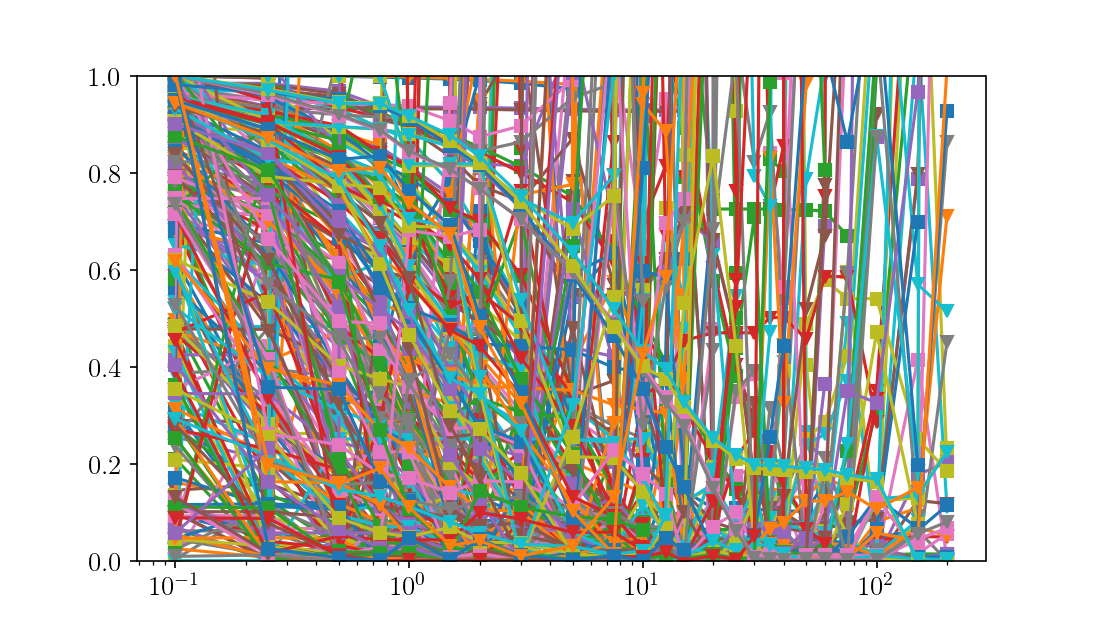

(0, 1)

In [321]:
plt.figure()
for corr in cr:
   # plt.plot(corr_ks,corr['AE']**2.0,'x-')
    plt.plot(corr_ks,corr['aod1040']**2.0,'s-')
    plt.plot(corr_ks,corr['aod0500']**2.0,'v-')
plt.xscale('log')
plt.ylim(0,1)

### Integrated autocorrelation

In [193]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

In [194]:
def autocorr2(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]/result.max()

In [195]:
def autocorr5(x):
    '''numpy.correlate, non partial'''
    n = len(x)
    lags = range(n)
    #mean=x.mean()
    var=np.nanvar(x)
    xp=x-np.nanmean(x)
    corr=np.correlate(xp,xp,'full')[n-1:]/var/n

    return corr[:n]

In [196]:
authcor = autocorr(dvals['aod0500'][1])
authcor2 = autocorr2(dvals['aod0500'][1])
authcor3 = autocorr5(dvals['aod0500'][1])

In [197]:
len(authcor2)

150

In [198]:
len(dvals['aod0500'][1])

150

In [199]:
dvals['dist'][1]

array([ 1.06481196e-01,  1.07250931e-01,  1.00681330e-01,  1.07341610e-01,
        8.69167146e-01,  1.06458801e-01,  1.07656959e-01,  1.07331664e-01,
        1.07649960e-01,  1.07674690e-01,  1.11647259e-01,  1.80954556e-01,
        1.03262300e+00,  1.43802620e-01,  1.58208826e-01,  9.51512382e-02,
        1.38772160e-02,  2.20330108e-01,  1.19280697e-01,  1.14420705e-01,
        1.13232525e-01,  1.80996198e-01,  1.58180858e-01,  1.13570789e-01,
        1.14412142e-01,  1.12567644e-01,  1.09654413e-01,  1.20703305e-01,
        1.12859373e-01,  1.14339927e-01,  1.14415309e-01,  1.13227154e-01,
        1.85477559e-01,  1.64961149e-01,  1.17239249e-01,  1.14405573e-01,
        1.13993694e-01,  1.13103587e-01,  1.14738645e-01,  1.19590922e-01,
        1.14638736e-01,  1.14407733e-01,  1.17310389e-01,  1.89948391e-01,
        1.65940173e-01,  1.15870761e-01,  1.13055610e-01,  1.12332776e-01,
        1.10547653e-01,  1.11808799e-01,  1.10467251e-01,  1.11981989e-01,
        1.11182131e-01,  

In [200]:
[(dvals['dist'][i].mean(),np.size(dvals['dist'][i])) for i in xrange(len(dvals['dist']))]

[(0.027810863396092143, 1399),
 (0.07922729735734811, 149),
 (0.5092342094481336, 859),
 (0.3091444650740662, 376),
 (0.1165757481628561, 66),
 (0.09733106184325929, 939),
 (0.11255256410449042, 64),
 (0.12107382384126608, 2),
 (0.12647841840014587, 99),
 (0.1958055922118615, 1171),
 (0.8661174565074323, 106),
 (0.15142106162476907, 78),
 (0.13978965343665184, 49),
 (0.17584446141423019, 329),
 (0.05805132406036755, 27),
 (0.08803829684509726, 10),
 (0.24752162640782457, 1666),
 (0.1499244128630026, 215),
 (0.1344330978692005, 41),
 (0.13342682762009722, 35),
 (0.13463467852772917, 219),
 (0.10611934608691116, 9),
 (0.02329074636928539, 2860),
 (0.228787625962917, 90),
 (0.10799369369205011, 258),
 (0.06520551339862435, 1467),
 (0.12132977368120482, 166),
 (0.10525581107680525, 117),
 (0.10691224620045008, 2),
 (0.10986877128049924, 2),
 (0.1191751022725345, 20),
 (0.11169653958040217, 46),
 (0.086904815526222, 288),
 (0.12407996157738535, 783),
 (0.13069215698254336, 875),
 (0.1158100

### interpolate AODs to a constant distance grid

In [204]:
def interp_dist(d,dist=0.12,verbose=False):
    'function to insterpolate the AOD from the dict to an even grid spacing accroding to distance (default 0.12 km)'
    d['cdist_n'],d['aod_n'] = [],[]
    for i,cd in enumerate(d['cumdist']):
        if verbose:
            print i, cd.min(),cd.max(), np.nanmin(cd),np.nanmax(cd)
            if not np.isfinite(cd.min()): print cd
        d['cdist_n'].append(np.arange(cd.min(),cd.max(),dist))
        try:
            fcd = interpolate.interp1d(cd,d['aod0500'][i])
            d['aod_n'].append(fcd(d['cdist_n'][i]))
        except TypeError:
            d['aod_n'].append(np.array(np.nan))

In [202]:
dvals['aod0500']

array([array([0.561, 0.561, 0.56 , ..., 0.463, 0.439, 0.446]),
       array([0.229, 0.225, 0.22 , 0.218, 0.216, 0.218, 0.218, 0.222, 0.221,
       0.234, 0.294, 0.317, 0.514, 0.59 , 0.59 , 1.608, 0.272, 0.267,
       0.244, 0.241, 0.253, 0.248, 0.262, 0.352, 0.352, 0.536, 0.747,
       0.391, 0.955, 0.571, 0.334, 0.336, 0.425, 0.527, 0.409, 0.409,
       0.399, 1.51 , 0.764, 0.387, 0.348, 0.318, 0.274, 0.278, 0.309,
       0.304, 0.304, 0.267, 0.265, 0.268, 0.271, 0.276, 0.278, 0.28 ,
       0.282, 0.31 , 0.378, 0.378, 0.347, 0.496, 0.384, 0.352, 0.343,
       0.338, 0.339, 0.342, 0.592, 0.592, 1.175, 2.039, 2.039, 2.662,
       1.33 , 0.672, 0.785, 0.922, 0.935, 0.379, 0.379, 0.366, 0.352,
       0.339, 0.351, 0.341, 0.325, 0.332, 0.328, 0.32 , 0.328, 0.328,
       0.349, 0.33 , 0.341, 0.324, 0.309, 0.313, 0.318, 0.332, 0.324,
       0.307, 0.307, 0.28 , 0.27 , 0.264, 0.261, 0.267, 0.257, 0.255,
       0.259, 0.259, 0.25 , 0.247, 0.246, 0.252, 0.255, 0.251, 0.246,
       0.25 , 0.238,

In [205]:
interp_dist(dvals)

In [206]:
dvals['autocor'] = [] 
for i,a in enumerate(dvals['aod_n']):
    try:
        dvals['autocor'].append(autocorr5(a))
    except:
        dvals['autocor'].append(np.array(np.nan))

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
  
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


### Autocorrelation plots

<IPython.core.display.Javascript object>


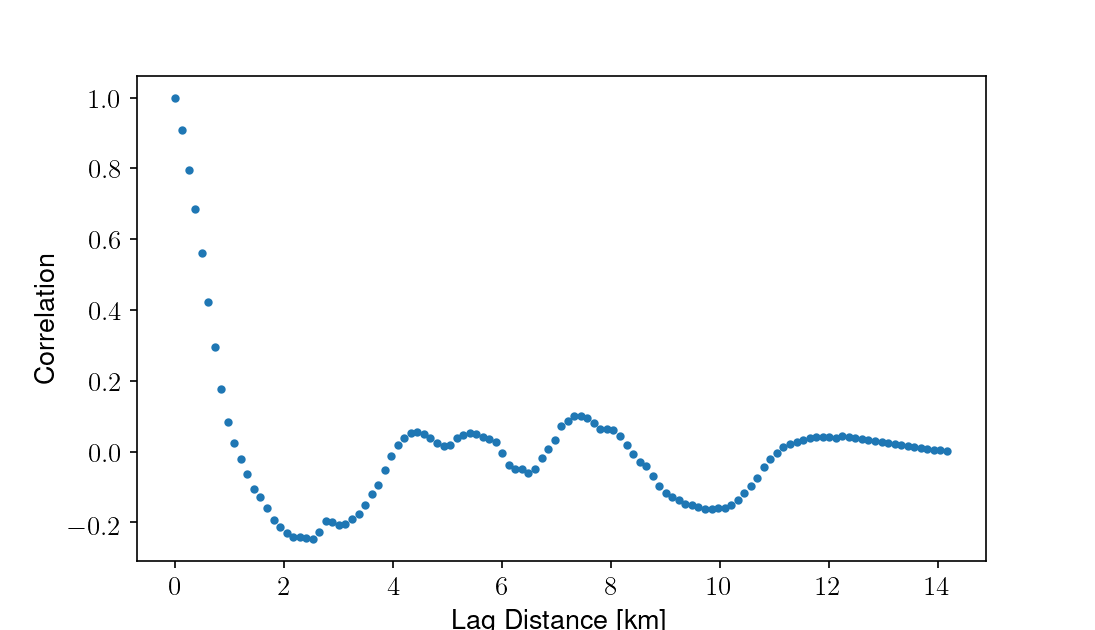

Text(0,0.5,'Correlation')

In [207]:
plt.figure()
plt.plot(dvals['cdist_n'][1],dvals['autocor'][1],'.')
plt.xlabel('Lag Distance [km]')
plt.ylabel('Correlation')

<IPython.core.display.Javascript object>


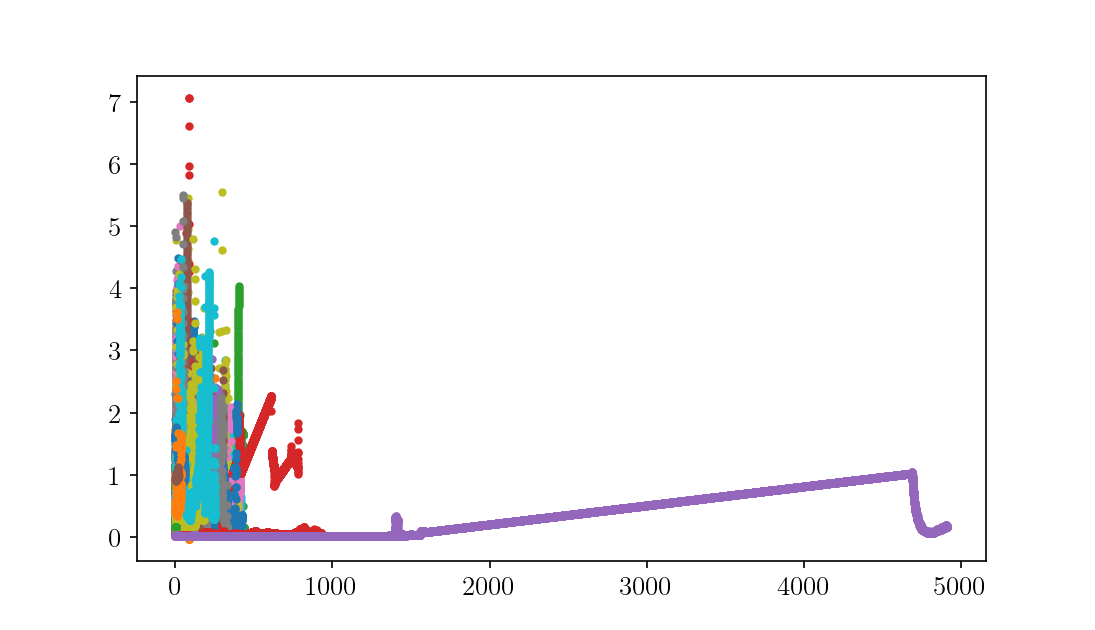

In [208]:
plt.figure()
for i,j in enumerate(dvals['cdist_n']):
    try:
        plt.plot(j,dvals['aod_n'][i],'.')
    except:
        pass

<IPython.core.display.Javascript object>


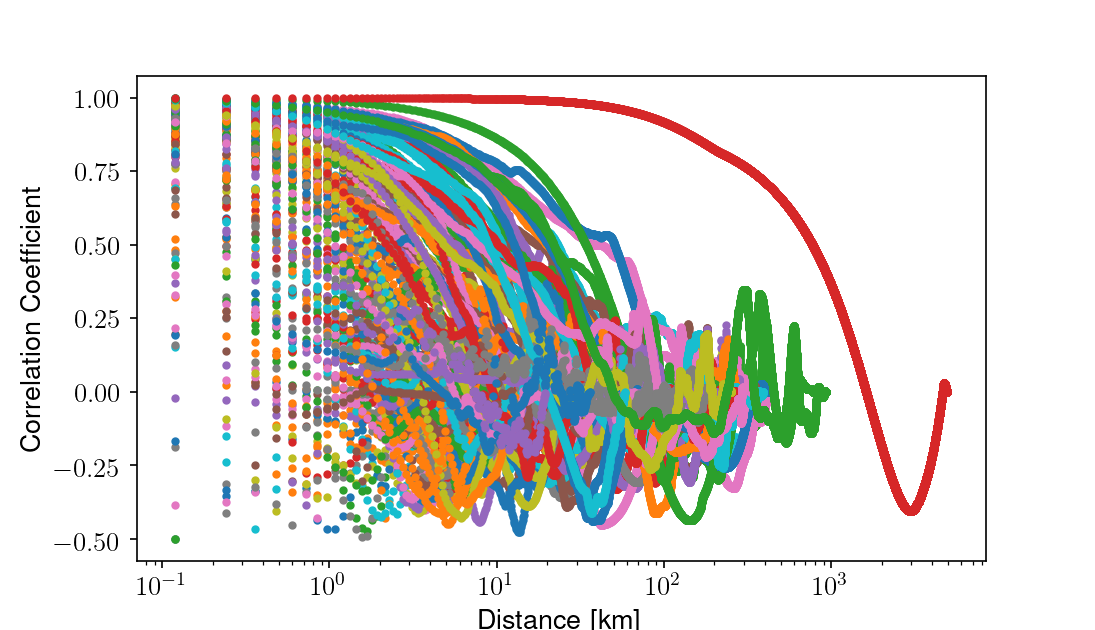

In [209]:
plt.figure()
for i,j in enumerate(dvals['cdist_n']):
    try:
        plt.plot(j,dvals['autocor'][i],'.')
    except:
        pass
plt.ylabel('Correlation Coefficient')
plt.xlabel('Distance [km]')
plt.xscale('log')

## Now get the angstrom exponent and plot it vertically

In [210]:
nwl,nm

([u'AOD0380',
  u'AOD0452',
  u'AOD0501',
  u'AOD0520',
  u'AOD0532',
  u'AOD0550',
  u'AOD0606',
  u'AOD0620',
  u'AOD0675',
  u'AOD0781',
  u'AOD0865',
  u'AOD1020',
  u'AOD1040',
  u'AOD1064',
  u'AOD1236',
  u'AOD1559',
  u'AOD1627'],
 [380.0,
  452.0,
  501.0,
  520.0,
  532.0,
  550.0,
  606.0,
  620.0,
  675.0,
  781.0,
  865.0,
  1020.0,
  1040.0,
  1064.0,
  1236.0,
  1559.0,
  1627.0])

In [89]:
aodrr = np.array([ar[n] for n in nwl])

In [90]:
aodrr.shape

(17, 583183)

In [91]:
angs = su.calc_angs(ar['Start_UTC'],np.array(nm[1:11]),aodrr[1:11,:])

A Jupyter Widget

Sun_utils.py:607: RuntimeWarning: divide by zero encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))
linfit.py:224: RuntimeWarning: invalid value encountered in double_scalars
  yint = (sy - sx * slope)/s
Sun_utils.py:607: RuntimeWarning: invalid value encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))


In [44]:
def make_bined_alt(x,alt,days,fl,n=70):
    'Function to create binned data for a set range, usually for altitude'
    binned_ang,binned_alt,binned_num,binned_ndays = [],[],[],[]
    for i in xrange(70):
        flaa = (alt[fl]>=i*100.0) & (alt[fl]<(i+1.0)*100.0)
        binned_ang.append(x[fl][flaa])
        binned_alt.append(np.mean([i*100.0,(i+1.0)*100.0]))
        binned_num.append(len(x[fl][flaa]))
        binned_ndays.append(len(np.unique(days[fl][flaa])))
    return binned_ang,binned_alt,binned_num,binned_ndays

In [45]:
ar['fl_QA_angs'] = ar['fl'] & (ar['AOD0501']>0.05) 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [46]:
ar['fl_QA_angs_seoul'] = ar['fl'] & (ar['AOD0501']>0.05) & (ar['Latitude']<37.75) &\
                        (ar['Latitude']>36.9) & (ar['Longitude']<127.30) & (ar['Longitude']>126.60)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [47]:
any(ar['fl_QA_angs_seoul'])

True

In [70]:
bang,balt,bnum,bndays = make_bined_alt(angs,ar['GPS_Alt'],ar['days'],ar['fl_QA_angs'],n=90)

In [71]:
bangs,balts,bnums,bndayss = make_bined_alt(angs,ar['GPS_Alt'],ar['days'],ar['fl_QA_angs_seoul'],n=90)

### Plotting of the angstrom vertical dependence

<IPython.core.display.Javascript object>


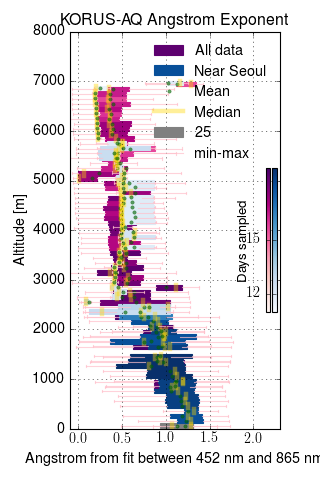

In [128]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(bang,positions=np.array(balt)-5.0,vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('Angstrom from fit between 452 nm and 865 nm')
plt.ylabel('Altitude [m]')
gr = plt.cm.RdPu
bl = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,bndays)
    
bpc =plt.boxplot(bangs,positions=np.array(balts)+10.0,vert=False,
                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(bl,bpc,bndayss)
bpc['boxes'][0].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ Angstrom Exponent')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(-0.1,2.3)
plt.grid()
plt.legend([bp['boxes'][5],bpc['boxes'][18],bpc['means'][0],bpc['medians'][0],bpc['boxes'][0],bpc['whiskers'][0]],
           ['All data','Near Seoul','Mean','Median','25% - 75%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(bndays)
scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
scalarmapbl.set_array(bndays)
cbaxesgr = plt.gcf().add_axes([0.83, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
cbg.set_ticks([0,3,6,9,12,15])
cbb.set_ticks([0,3,6,9,12,15]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left'),cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-6.0,0.5,'Days sampled',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_Angstrom_fit_vertical.png',
            transparent=True,dpi=500)

## Calculate the Fine mode fraction

In [48]:
fmf = su.sda(aodrr[1:13,:],np.array(nm[1:13])/1000.0)

HBox(children=(IntProgress(value=0, max=583185), HTML(value=u'')))

Sun_utils.py:418: RuntimeWarning: divide by zero encountered in log
  cc = polyfit(np.log(wvl),np.log(aod),polynum)
Sun_utils.py:418: RuntimeWarning: invalid value encountered in log
  cc = polyfit(np.log(wvl),np.log(aod),polynum)


In [49]:
fmf.keys()

['tauc', 'alphap', 'tauf', 'tau', 'poly', 'eta', 'alpha']

In [50]:
ar['fl_QA_low'] = ar['fl_QA'] & (ar['GPS_Alt']<500.0)
ar['fl_QA_mid'] = ar['fl_QA'] & (ar['GPS_Alt']>2000.0) & (ar['GPS_Alt']<5000.0) 


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [51]:
ar['fl_QA_fmf'] = ar['fl_QA'] & (np.isfinite(fmf['tauf'])) & (np.isfinite(fmf['tauc']))

In [52]:
bfaod,baltf,bnumf,bndaysf = make_bined_alt(fmf['tauf'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
bcaod,baltc,bnumc,bndaysc = make_bined_alt(fmf['tauc'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
beta,balte,bnume,bndayse = make_bined_alt(fmf['eta'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)

In [53]:
blat,baltl,bnuml,bndaysl = make_bined_alt(ar['Latitude'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
blon,baltlo,bnumlo,bndayslo = make_bined_alt(ar['Longitude'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)

583185/|/100%|| 583185/583185 [01:35<00:00, 7578.34it/s]

In [54]:
blats = [np.nanmedian(ll) for ll in blat]
blons = [np.nanmedian(ll) for ll in blon]

In [90]:
blons

[-149.98910000000001,
 126.12313779999999,
 126.65381360000001,
 126.4886552,
 127.1281,
 127.32114919999999,
 127.2359708,
 127.2046137,
 127.14304390000001,
 127.1601344,
 127.1606122,
 127.00119480000001,
 126.90518785,
 127.42745955000001,
 126.95736264999999,
 127.02680789999999,
 127.3059449,
 127.3743758,
 127.3411138,
 127.32306635,
 127.47791185,
 127.2584296,
 127.2898993,
 127.47796245000001,
 126.8234029,
 126.92522649999999,
 127.51896975,
 127.47839999999999,
 126.87634489999999,
 127.52080530000001,
 127.47686179999999,
 128.39919265,
 127.46392815,
 127.467461,
 128.41734845000002,
 127.469979,
 127.4882752,
 127.50116735,
 126.82570990000001,
 127.531677,
 127.55323344999999,
 127.58127114999999,
 126.99032579999999,
 127.6203627,
 127.63433664999999,
 127.63790815,
 127.6442557,
 124.2892319,
 127.6469683,
 127.63876740000001,
 126.95364925,
 127.3740899,
 127.5705,
 127.46281429999999,
 127.56150839999999,
 127.54370900000001,
 127.51926324999999,
 127.48308965,
 127

### Plot the fine mode fraction distribution

<IPython.core.display.Javascript object>


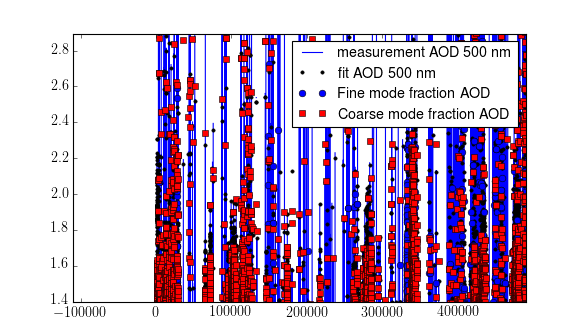

(0, 1.5)

In [87]:
plt.figure()
plt.plot(aodrr[2,:],label='measurement AOD 500 nm')
plt.plot(fmf['tau'],'.k',label='fit AOD 500 nm')
plt.plot(fmf['tauf'], 'ob',label='Fine mode fraction AOD')
plt.plot(fmf['tauc'],'sr',label='Coarse mode fraction AOD')
plt.legend()
plt.ylim(0,1.5)

<IPython.core.display.Javascript object>


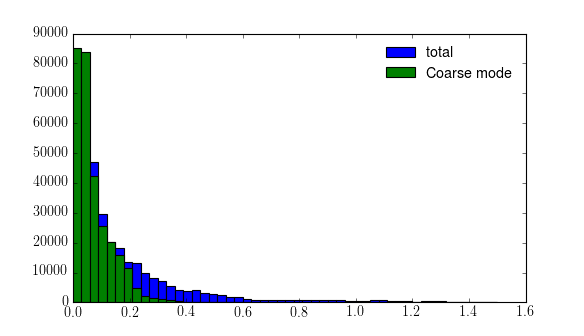

In [96]:
plt.figure()
plt.hist(fmf['tauc'][ar['fl_QA']]+fmf['tauf'][ar['fl_QA']],range=[0,1.5],bins=50,label='total')
plt.hist(fmf['tauc'][ar['fl_QA']],range=[0,1.5],bins=50,label='Coarse mode')
plt.legend(frameon=False)

In [106]:
any(ar['fl_QA_mid'])

True

### Plot the histogram distribution of the fine mode fraction

<IPython.core.display.Javascript object>


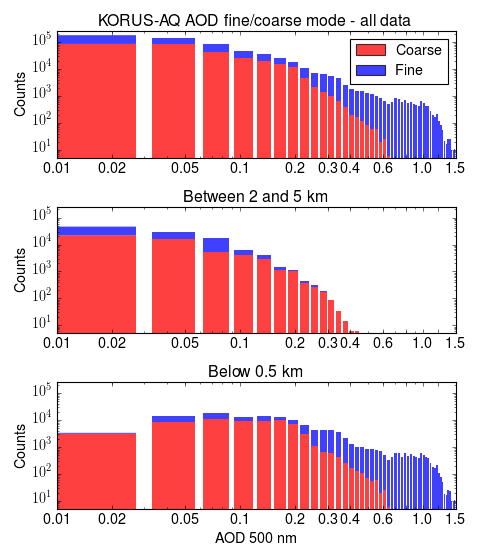

In [61]:
plt.figure(figsize=(6,7))
ax1 = plt.subplot(3,1,1)
plt.hist([fmf['tauc'][ar['fl_QA']],fmf['tauf'][ar['fl_QA']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
plt.legend(frameon=True,loc=1)
plt.title('KORUS-AQ AOD fine/coarse mode - all data')
#plt.xlabel('AOD 500 nm')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax1.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

ax2 = plt.subplot(3,1,2,sharex=ax1)
plt.hist([fmf['tauc'][ar['fl_QA_mid']],fmf['tauf'][ar['fl_QA_mid']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
#plt.legend(frameon=False)
plt.title('Between 2 and 5 km')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax2.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

ax3 = plt.subplot(3,1,3,sharex=ax2)
plt.hist([fmf['tauc'][ar['fl_QA_low']],fmf['tauf'][ar['fl_QA_low']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
#plt.legend(frameon=False)
plt.title('Below 0.5 km')
#plt.xlabel('AOD 500 nm')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xlabel('AOD 500 nm')
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax3.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_hist.png',
            transparent=True,dpi=500)

### Plot the vertical dependence of the fine mode fraction

<IPython.core.display.Javascript object>


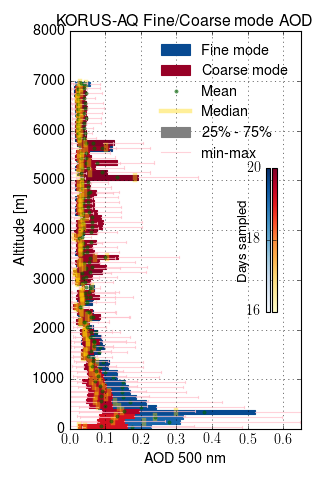

In [110]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(bfaod,positions=np.array(baltf)-5.0,vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('AOD 500 nm')
plt.ylabel('Altitude [m]')
bl = plt.cm.YlOrRd
gr = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,bndaysf)
    
bpc =plt.boxplot(bcaod,positions=np.array(baltc)+10.0,vert=False,
                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(bl,bpc,bndaysc)
bpc['boxes'][-1].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ Fine/Coarse mode AOD')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(0.0,0.65)
plt.grid()
plt.legend([bp['boxes'][5],bpc['boxes'][18],bpc['means'][0],bpc['medians'][0],bpc['boxes'][-1],bpc['whiskers'][0]],
           ['Fine mode','Coarse mode','Mean','Median','25\% - 75\%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(bndaysf)
scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
scalarmapbl.set_array(bndaysc)
cbaxesgr = plt.gcf().add_axes([0.83, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
cbg.set_ticks([0,6,12,16,18,20])
cbb.set_ticks([0,6,12,16,18,20]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left'),cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-6.0,0.5,'Days sampled',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_AOD_vertical.png',
            transparent=True,dpi=500)

In [56]:
blats[0]=36.2

In [57]:
bndm = np.nanmax(blats)*1.0
bndm

37.594356000000005

In [100]:
cl = gr
for j,q in enumerate(blats):
    print j, q, cl(blats[j]*1.0/bndm)

0 36.2 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
1 35.6241051 (0.031372550874948502, 0.24101500084587171, 0.49797771315948636, 1.0)
2 36.2642631 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
3 36.4941735 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
4 36.1079282 (0.031372550874948502, 0.2288350693735422, 0.47989235964475896, 1.0)
5 36.6140062 (0.031372550874948502, 0.2125951607437695, 0.45577855495845571, 1.0)
6 36.4494213 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
7 36.8572909 (0.031372550874948502, 0.20853518358632631, 0.44975010378687991, 1.0)
8 36.98560035 (0.031372550874948502, 0.20447520642888312, 0.44372165261530405, 1.0)
9 36.149323 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
10 37.0671798 (0.031372550874948502, 0.20041522927143995, 0.43769320144372825, 1.0)
11 36.53188675 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
12 36.123

<IPython.core.display.Javascript object>


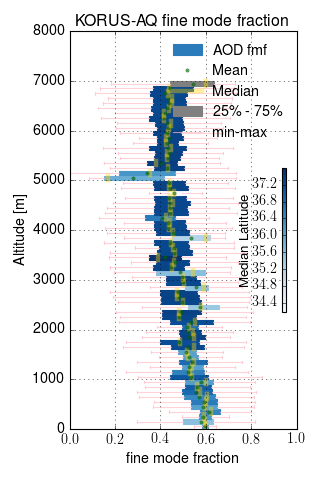

In [111]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(beta,positions=np.array(balte),vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('fine mode fraction')
plt.ylabel('Altitude [m]')
bl = plt.cm.YlOrRd
gr = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,blats,color_not_start_at_zero=True)
    
#bpc =plt.boxplot(bcaod,positions=np.array(baltc)+10.0,vert=False,
#                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
#pu.set_box_whisker_color(bl,bpc,bndaysc)
bp['boxes'][-1].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ fine mode fraction')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(0.0,1.0)
plt.grid()
plt.legend([bp['boxes'][5],bp['means'][5],bp['medians'][5],bp['boxes'][-1],bp['whiskers'][5]],
           ['AOD fmf','Mean','Median','25\% - 75\%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(blats)
#scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
#scalarmapbl.set_array(bndays)
cbaxesgr = plt.gcf().add_axes([0.88, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
#cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
#cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
#cbg.set_ticks([0,6,12,15,18])
#cbb.set_ticks([0,6,12,15,18]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left')#,cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-9.0,0.5,'Median Latitude',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_AOD_vertical.png',
            transparent=True,dpi=500)

## Calculate the autocorrelation of the fine and coarse mode AOD

In [55]:
fvals = {'utc':ar['Start_UTC'][fl],'alt':ar['GPS_Alt'][fl],'lat':ar['Latitude'][fl],'lon':ar['Longitude'][fl],
        'aod0500':ar['AOD0501'][fl],'aod1040':ar['AOD1040'][fl],'aodf':fmf['tauf'][fl],'aodc':fmf['tauc'][fl],'eta':fmf['eta'][fl]}

In [56]:
dfvals = get_segments(f_level,fvals,nsep=100)

In [57]:
ddfv = get_distances(dfvals)

Now the segments are identified and the cumulative distances are quantified, we must interpolate over the segments, to remove any missing data.

In [58]:
def interp_dist_fmf(d,dist=0.12):
    'function to insterpolate the AOD from the dict to an even grid spacing accroding to distance (default 0.12 km)'
    d['cdist_n'],d['aod_nf'],d['aod_nc'],d['eta_n'] = [],[],[],[]
    for i,cd in enumerate(d['cumdist']):        
        d['cdist_n'].append(np.arange(cd.min(),cd.max(),dist))
        if np.sum(np.isfinite(d['aodf'][i]))/float(len(d['aodf'][i])) < 0.75: # check if at least 75% of the segment is valid
            af = np.array(np.nan)
            ac = np.array(np.nan)
            et = np.array(np.nan)
        else:
            try:
                fcdf = interpolate.interp1d(cd,d['aodf'][i])
                af = fcdf(d['cdist_n'][i])
                fcdc = interpolate.interp1d(cd,d['aodc'][i])
                ac = fcdc(d['cdist_n'][i])
                fcde = interpolate.interp1d(cd,d['eta'][i])
                et = fcde(d['cdist_n'][i])
            except TypeError:
                af = np.array(np.nan)
                ac = np.array(np.nan)
                et = np.array(np.nan)
        d['aod_nf'].append(af)
        d['aod_nc'].append(ac)
        d['eta_n'].append(et)

In [59]:
interp_dist_fmf(dfvals)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [79]:
dfvals['autocor_f'],dfvals['autocor_c'],dfvals['autocor_e'] = [] ,[],[]
for i,a in enumerate(dfvals['aod_nf']):
    #auf,auc,eut = [],[],[]
    try:
        auf = autocorr5(a)
        auc = autocorr5(dfvals['aod_nc'][i])
        eut = autocorr5(dfvals['eta_n'][i])
    except:
        auf = np.array([np.nan])
        auc = np.array([np.nan])
        eut = np.array([np.nan])
    dfvals['autocor_f'].append(auf[:])
    dfvals['autocor_c'].append(auc[:])
    dfvals['autocor_e'].append(eut[:])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


In [61]:
len(dfvals['aod_nf'])

254

In [63]:
dfvals['aod_nf'][i]

array([ 0.21168928,  0.21168928,  0.22265097,  0.18114966,  0.16894319,
        0.14674936,  0.14672834,  0.15728576,  0.15866941,  0.15583983,
        0.15088238,  0.14901555,  0.16081026,  0.14932608,  0.1555551 ,
        0.17023048,  0.17848   ,  0.18110492,  0.17049711,  0.16931724,
        0.18223482,  0.14611177,  0.1545911 ,  0.13131177,  0.1258004 ,
        0.12972138,  0.13774946,  0.12761112,  0.13404419,  0.12955565,
        0.12202962,  0.1221877 ,  0.12350845,  0.1254407 ,  0.12568505,
        0.12544021,  0.13007457,  0.1446063 ,  0.15497749,  0.15668431,
        0.1568587 ,  0.15655648,  0.15642829,  0.14921399,  0.15069467,
        0.15802497,  0.15902921,  0.16477269,  0.1716531 ,  0.16922366,
        0.17200509,  0.1778292 ,  0.18154031,  0.17671224,  0.17589078,
        0.19670331,  0.16789232,  0.1615145 ,  0.17067411,  0.16942956,
        0.1661013 ,  0.1644251 ,  0.15779499,  0.16391675,  0.16363495,
        0.15439554,  0.15441867,  0.15563899,  0.16139322,  0.15

In [64]:
dfvals['cdist_n'][i]

array([  0.  ,   0.12,   0.24,   0.36,   0.48,   0.6 ,   0.72,   0.84,
         0.96,   1.08,   1.2 ,   1.32,   1.44,   1.56,   1.68,   1.8 ,
         1.92,   2.04,   2.16,   2.28,   2.4 ,   2.52,   2.64,   2.76,
         2.88,   3.  ,   3.12,   3.24,   3.36,   3.48,   3.6 ,   3.72,
         3.84,   3.96,   4.08,   4.2 ,   4.32,   4.44,   4.56,   4.68,
         4.8 ,   4.92,   5.04,   5.16,   5.28,   5.4 ,   5.52,   5.64,
         5.76,   5.88,   6.  ,   6.12,   6.24,   6.36,   6.48,   6.6 ,
         6.72,   6.84,   6.96,   7.08,   7.2 ,   7.32,   7.44,   7.56,
         7.68,   7.8 ,   7.92,   8.04,   8.16,   8.28,   8.4 ,   8.52,
         8.64,   8.76,   8.88,   9.  ,   9.12,   9.24,   9.36,   9.48,
         9.6 ,   9.72,   9.84,   9.96,  10.08,  10.2 ,  10.32,  10.44,
        10.56,  10.68,  10.8 ,  10.92,  11.04,  11.16,  11.28,  11.4 ,
        11.52,  11.64,  11.76,  11.88,  12.  ,  12.12,  12.24,  12.36,
        12.48,  12.6 ,  12.72,  12.84,  12.96,  13.08,  13.2 ,  13.32,
      

In [80]:
dfvals['autocor_f'][i]

array([             nan,              nan,              nan, ...,
         1.11008864e-05,   2.89227404e-06,  -5.78250967e-06])

In [111]:
mc = np.max([len(m) for m in dfvals['autocor_c']])
imc = np.argmax([len(m) for m in dfvals['autocor_c']])

In [113]:
cdist = dfvals['cdist_n'][imc]

In [123]:
autocor_c = np.zeros((len(dfvals['autocor_c']),mc))+np.nan
autocor_f = np.zeros((len(dfvals['autocor_f']),mc))+np.nan
autocor_e = np.zeros((len(dfvals['autocor_e']),mc))+np.nan

In [124]:
for i,c in enumerate(dfvals['autocor_c']): autocor_c[i,:len(c)]=c
for i,c in enumerate(dfvals['autocor_f']): autocor_f[i,:len(c)]=c
for i,c in enumerate(dfvals['autocor_e']): autocor_e[i,:len(c)]=c

### Plot out the autocorrelation 

<IPython.core.display.Javascript object>


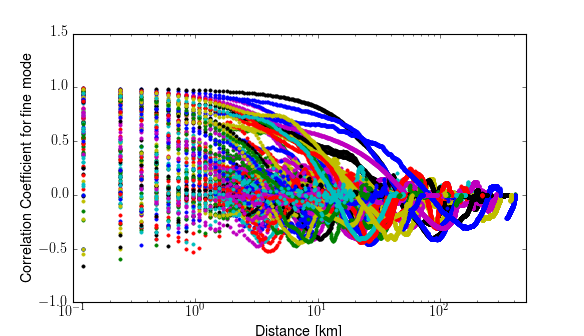

(0.1, 500)

In [83]:
plt.figure()
for i,j in enumerate(dfvals['cdist_n']):
    try:
        if len(j)<1: continue
        plt.plot(j,dfvals['autocor_f'][i],'.')
    except:
        continue
plt.ylabel('Correlation Coefficient for fine mode')
plt.xlabel('Distance [km]')
plt.xscale('log')
plt.xlim(0.1,500)

<IPython.core.display.Javascript object>


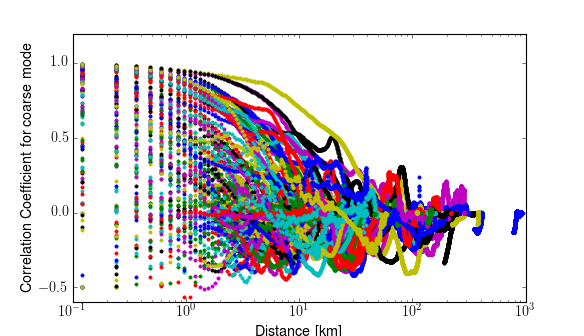

In [84]:
plt.figure()
for i,j in enumerate(dfvals['cdist_n']):
    try:
        plt.plot(j,dfvals['autocor_c'][i],'.')
    except:
        pass
plt.ylabel('Correlation Coefficient for coarse mode')
plt.xlabel('Distance [km]')
plt.xscale('log')

In [110]:
dfvals['cdist_n'][1:3]

[array([  0.  ,   0.12,   0.24,   0.36,   0.48,   0.6 ,   0.72,   0.84,
          0.96,   1.08,   1.2 ,   1.32,   1.44,   1.56,   1.68,   1.8 ,
          1.92,   2.04,   2.16,   2.28,   2.4 ,   2.52,   2.64,   2.76,
          2.88,   3.  ,   3.12,   3.24,   3.36,   3.48,   3.6 ,   3.72,
          3.84,   3.96,   4.08,   4.2 ,   4.32,   4.44,   4.56,   4.68,
          4.8 ,   4.92,   5.04,   5.16,   5.28,   5.4 ,   5.52,   5.64,
          5.76,   5.88,   6.  ,   6.12,   6.24,   6.36,   6.48,   6.6 ,
          6.72,   6.84,   6.96,   7.08,   7.2 ,   7.32,   7.44,   7.56,
          7.68,   7.8 ,   7.92,   8.04,   8.16,   8.28,   8.4 ,   8.52,
          8.64,   8.76,   8.88,   9.  ,   9.12,   9.24,   9.36,   9.48,
          9.6 ,   9.72,   9.84,   9.96,  10.08,  10.2 ,  10.32,  10.44,
         10.56,  10.68,  10.8 ,  10.92,  11.04,  11.16,  11.28,  11.4 ,
         11.52,  11.64,  11.76,  11.88,  12.  ,  12.12,  12.24,  12.36,
         12.48,  12.6 ,  12.72,  12.84,  12.96,  13.08,  13.2 , 

In [133]:
autocor_c_ma = np.ma.masked_array(autocor_c,mask=np.isnan(autocor_c))

In [157]:
def make_binned(x,alt,fl,bn,flb):
    'Function to create binned data for a set range, usually for altitude'
    import numpy as np
    binned_ang,binned_alt,binned_num = [],[],[]
    for i,b in enumerate(bn[:-1]):
        flaa = (alt[flb]>=b) & (alt[flb]<bn[i+1])
        binned_ang.append(x[:,flb][flaa])
        binned_alt.append(np.mean([b,bn[i+1]]))
        binned_num.append(len(x[fl][:,flaa]))
    return binned_ang,binned_alt,binned_num,binned_ndays

In [154]:
bnc = np.logspace(0.1,3.0)

In [155]:
bnc

array([    1.25892541,     1.44272539,     1.6533597 ,     1.89474609,
           2.1713743 ,     2.48838954,     2.85168821,     3.26802759,
           3.74515148,     4.29193426,     4.91854597,     5.63664143,
           6.45957703,     7.40265918,     8.48342898,     9.72198848,
          11.14137457,    12.7679875 ,    14.63208187,    16.76832937,
          19.21646368,    22.0220195 ,    25.23717948,    28.92174481,
          33.14424749,    37.98322505,    43.52868128,    49.8837603 ,
          57.16666502,    65.51285569,    75.0775694 ,    86.03870748,
          98.60014441,   112.99551984,   129.49258422,   148.3981789 ,
         170.06394329,   194.89285531,   223.34672663,   255.95479227,
         293.32355425,   336.14806238,   385.224842  ,   441.46670918,
         505.91974884,   579.78277172,   664.42961191,   761.43467988,
         872.60224609,  1000.        ])

In [163]:
auc = make_binned(autocor_c,cdist,np.isfinite(autocor_c),bnc)

IndexError: too many indices for array

In [161]:
b = bnc[0]
i = 0
fl = np.isfinite(autocor_c)

In [162]:
flaa = (cdist[fl]>=b) & (cdist[fl]<bnc[i+1])

IndexError: too many indices for array

In [156]:
autocor_c.shape

(254, 7728)

<IPython.core.display.Javascript object>


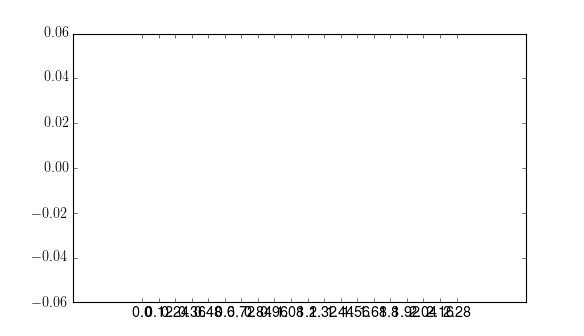

In [135]:
plt.figure()
bp = plt.boxplot(autocor_c_ma[:,0:20],positions=cdist[0:20],vert=True,
            showfliers=False,widths=90,showmeans=True,patch_artist=True) 

In [118]:
autocor_c.shape

(254, 7728)

In [134]:
autocor_c_ma[:,0:20]

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [0.9999999999999999 0.9486627690818289 0.8831168001028755 ...,
  0.039102311665049704 -0.01640918562484604 -0.07094585321604496]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [1.0 0.9001915471544049 0.7544360646884336 ..., -0.38939146620925097
  -0.332314722022007 -0.2539286515417791]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [False False False ..., False False False]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [False False False ..., False False False]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [130]:
np.isfinite(autocor_c)

array([[False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [136]:
autocor_c_ma[:,0]

masked_array(data = [-- 0.9999999999999999 -- -- 0.9999999999999998 1.0 -- 1.0 -- -- --
 1.0000000000000002 1.0 1.0 -- 1.0 1.0 1.0000000000000002 1.0 -- -- -- 1.0
 0.9999999999999998 -- 0.9999999999999999 -- 1.0 -- 1.0 1.0 1.0
 0.9999999999999997 1.0 -- -- 1.0 1.0000000000000004 0.9999999999999999
 0.9999999999999998 -- 1.0 1.0 1.0 1.0 0.9999999999999999 --
 1.0000000000000002 1.0000000000000002 1.0000000000000002 -- 1.0
 0.9999999999999999 -- 1.0 -- -- -- -- -- -- 1.0 -- -- 0.9999999999999998
 -- -- -- -- -- 1.0 0.9999999999999999 1.0000000000000002 -- -- -- 1.0 --
 -- 0.9999999999999999 -- 0.9999999999999998 -- -- 1.0000000000000002
 0.9999999999999998 1.0 -- 1.0000000000000002 -- -- -- -- -- -- -- 1.0 --
 1.0 --],
             mask = [ True False  True  True False False  True False  True  True  True False
 False False  True False False False False  True  True  True False False
  True False  True False  True False False False False False  True  True
 False False False False  True Fal